# Import

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import random
import pydot
import copy
import os
import itertools
import time
import datetime
import heapq
from statistics import mean, mode, median
from graphviz import Source
from collections import deque, defaultdict
from scipy.sparse import lil_matrix
from pgmpy.models import BayesianNetwork, NaiveBayes
from pgmpy.base import DAG
from pgmpy.factors.discrete import TabularCPD
from pgmpy.sampling import BayesianModelSampling, GibbsSampling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from pgmpy.estimators import HillClimbSearch, BicScore, ExpectationMaximization, MaximumLikelihoodEstimator, BayesianEstimator, TreeSearch
from pgmpy.inference import VariableElimination
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from networkx.drawing.nx_agraph import to_agraph
from sklearn.mixture import GaussianMixture


In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Helpers

In [3]:
def ground_truth():
    model_gt = BayesianNetwork([('PatientGender', 'AD'), ('FamilyHistory', 'AD'), ('PatientAge', 'AD'), ('ADTest', 'AD'),
                            ('FamilyHistory', 'APOE'), ('AD', 'APOE'),
                            ('AD', 'Hypometabilism'), ('AD', 'CognitiveImpair'), ('AD', 'MemoryImpair'),
                              ('AD', 'ABAccumulation'), ('CognitiveImpair', 'ABAccumulation'), ('Hypometabilism', 'ABAccumulation'),
                            ('MemoryImpair', 'HippocampusSize'), ('APOE', 'APOEAllele'), ('ABAccumulation', 'ABProtein'),
                            ('ABAccumulation', 'PPCGlucose'), ('Hypometabilism', 'PPCGlucose'),
                            ('ABAccumulation', 'BloodFlow'), ('CognitiveImpair', 'BloodFlow')])

    # conditional probability distributions
    cpd_gender = TabularCPD(variable='PatientGender', variable_card=2, values=[[0.4], [0.6]])
    cpd_history = TabularCPD(variable='FamilyHistory', variable_card=2, values=[[0.25], [0.75]])
    cpd_age = TabularCPD(variable='PatientAge', variable_card=4, values=[[0.2], [0.35], [0.3], [0.15]])
    cpd_test = TabularCPD(variable='ADTest', variable_card=2, values=[[0.35], [0.65]])

    # ---
    cpd_ad = TabularCPD(variable='AD', variable_card=2, 
                        values=[[0.9, 0.1, 0.9, 0.1, 0.95, 0.05, 0.95, 0.05, 0.95, 0.05, 0.95, 0.05, 0.9, 0.1, 0.9, 0.1, 0.85, 0.15, 0.85, 0.15, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.85, 0.15, 0.85, 0.15],
                                [0.1, 0.9, 0.1, 0.9, 0.05, 0.95, 0.05, 0.95, 0.05, 0.95, 0.05, 0.95, 0.1, 0.9, 0.1, 0.9, 0.15, 0.85, 0.15, 0.85, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.15, 0.85, 0.15, 0.85]],
                        evidence=['PatientGender', 'FamilyHistory', 'PatientAge', 'ADTest'],
                        evidence_card=[2, 2, 4, 2])

    # ---

    cpd_apoe = TabularCPD(variable='APOE', variable_card=2,
                            values=[[0.95, 0.15, 0.65, 0.05], [0.05, 0.85, 0.35, 0.95]],
                          evidence=['FamilyHistory', 'AD'],
                        evidence_card=[2, 2])

    cpd_hypo = TabularCPD(variable='Hypometabilism', variable_card=3,
                            values=[[0.35, 0.10], [0.4, 0.15], [0.25, 0.75]],
                          evidence=['AD'],
                        evidence_card=[2])

    cpd_cognitive = TabularCPD(variable='CognitiveImpair', variable_card=2,
                            values=[[0.75, 0.20], [0.25, 0.8]],
                          evidence=['AD'],
                        evidence_card=[2])

    cpd_memory = TabularCPD(variable='MemoryImpair', variable_card=2,
                            values=[[0.75, 0.15], [0.25, 0.85]],
                          evidence=['AD'],
                        evidence_card=[2])

    cpd_accumulation = TabularCPD(variable='ABAccumulation', variable_card=2,
                            values=[[0.75, 0.35, 0.25, 0.8, 0.75, 0.65,   0.35, 0.2, 0.1, 0.45, 0.3, 0.1],
                              [0.25, 0.65, 0.75, 0.2, 0.25, 0.35,  0.65, 0.8, 0.9, 0.55, 0.7, 0.9]],
                          evidence=['AD', 'Hypometabilism', 'CognitiveImpair'],
                        evidence_card=[2, 3, 2])

    cpd_hippo = TabularCPD(variable='HippocampusSize', variable_card=4,
                            values=[[0.15, 0.40], [0.3, 0.3], [0.3, 0.2], [0.25, 0.1]],
                          evidence=['MemoryImpair'],
                        evidence_card=[2])

    cpd_allele = TabularCPD(variable='APOEAllele', variable_card=2,
                            values=[[0.95, 0.05], [0.05, 0.95]],
                          evidence=['APOE'],
                        evidence_card=[2])

    cpd_protein = TabularCPD(variable='ABProtein', variable_card=2,
                            values=[[0.9, 0.1], [0.1, 0.9]],
                          evidence=['ABAccumulation'],
                        evidence_card=[2])

    cpd_glucose = TabularCPD(variable='PPCGlucose', variable_card=3,
                            values=[[0.75, 0.3, 0.25, 0.3, 0.25, 0.1],
                              [0.15, 0.45, 0.45, 0.45, 0.45, 0.15],
                              [0.1, 0.25, 0.3, 0.25, 0.3, 0.75]],
                          evidence=['Hypometabilism', 'ABAccumulation'],
                        evidence_card=[3, 2])

    cpd_blood = TabularCPD(variable='BloodFlow', variable_card=3,
                            values=[[0.5, 0.25, 0.35, 0.1],
                              [0.35, 0.45, 0.45, 0.25],
                              [0.15, 0.3, 0.2, 0.65]],
                          evidence=['CognitiveImpair', 'ABAccumulation'],
                        evidence_card=[2, 2])


    model_gt.add_cpds(cpd_gender, cpd_history, cpd_age, cpd_test, cpd_ad, cpd_apoe, cpd_hypo, cpd_cognitive, cpd_memory, cpd_accumulation, cpd_hippo, cpd_allele, cpd_protein, cpd_glucose, cpd_blood)

    return model_gt

In [4]:
def generate_synthetic_data(model_gt, n_samples):
    sampler = BayesianModelSampling(model_gt)
    data = sampler.forward_sample(size=n_samples)
    df = data.copy()

    df['PatientGender'] = df['PatientGender'].map({0: 'Male', 1: 'Female'})
    df['FamilyHistory'] = df['FamilyHistory'].map({0: 'No', 1: 'Yes'})
    df['PatientAge'] = df['PatientAge'].map({0: 'Less55', 1: 'less65', 2: 'less75', 3: 'less85'})
    df['ADTest'] = df['ADTest'].map({0: 'No', 1: 'Yes'})
    df['AD'] = df['AD'].map({0: 'No', 1: 'Yes'})
    df['APOE'] = df['APOE'].map({0: 'No', 1: 'Yes'})
    df['Hypometabilism'] = df['Hypometabilism'].map({0: 'Low', 1: 'Medium', 2: 'High'})
    df['CognitiveImpair'] = df['CognitiveImpair'].map({0: 'No', 1: 'Yes'})
    df['MemoryImpair'] = df['MemoryImpair'].map({0: 'No', 1: 'Yes'})
    df['ABAccumulation'] = df['ABAccumulation'].map({0: 'No', 1: 'Yes'})
    df['HippocampusSize'] = df['HippocampusSize'].map({0: 'Less2500', 1: 'less35000', 2: 'less4500', 3: 'less5500'})
    df['APOEAllele'] = df['APOEAllele'].map({0: 'Absent', 1: 'Present'})
    df['ABProtein'] = df['ABProtein'].map({0: 'No', 1: 'Yes'})
    df['PPCGlucose'] = df['PPCGlucose'].map({0: 'Low', 1: 'Medium', 2: 'High'})
    df['BloodFlow'] = df['BloodFlow'].map({0: 'Low', 1: 'Medium', 2: 'High'})

    data_df = df.copy()
    df = data.copy()

    return df, data_df

In [5]:
def get_state_space_sizes(df):
    state_spaces = {}
    for feature in df.columns:
        # Count the number of unique values for the feature
        state_spaces[feature] = df[feature].nunique()
    return state_spaces

In [6]:
def split_data(df, test_size=0.2, val_size=0.2):
    train_size = 1 - test_size - val_size
    
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(df.drop('AD', axis=1), df['AD'], test_size=test_size + val_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=test_size/(test_size + val_size), random_state=42)
    
    Tr = pd.concat([X_train, y_train], axis=1)
    Te = pd.concat([X_test, y_test], axis=1)
    Va = pd.concat([X_val, y_val], axis=1)
    
    return Tr, Te, Va

In [7]:
class NaiveBayesModel:
    def __init__(self, class_label, data):
        self.class_label = class_label
        # Extract features
        self.features = [f for f in data.columns if f != class_label]
        X = data[[col for col in data.columns if col != class_label]]
        y = data[class_label]
        X_train_temp, self.X_test, y_train_temp, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)
        self.model = CategoricalNB()
        self.model.fit(self.X_train, self.y_train)

    def predict(self, data):
        return self.model.predict(data[self.features])
    
    def visualize_model(self):
        G = nx.DiGraph()
        G.add_node(self.class_label, color='grey')
        for feature in self.features:
            G.add_node(feature)
            G.add_edge(self.class_label, feature)
        pos = nx.spring_layout(G)
        plt.figure(figsize=(10, 6))
        nx.draw(G, pos, with_labels=True, node_size=3000, node_shape='o', alpha=0.5, font_size=15)
        plt.title('Naive Bayes Model Structure')
        plt.show()

In [8]:
def add_model_predictions(Tr, models):
    result_df = Tr.copy()    
    for idx, model in enumerate(models):
        predictions = model.predict(result_df)
        result_df[f'Model_{model.class_label}'] = predictions

    return result_df

In [9]:
def introduce_missing_data(df, columns, missing_rate=1):
    """
    Introduces NaN values into specified columns of the DataFrame at the given missing rate.

    """
    df_missing = df.copy()
    for column in columns:
        if missing_rate == 1.0:
            df_missing[column] = np.nan
        else:
            mask = np.random.rand(len(df)) < missing_rate
            df_missing.loc[mask, column] = np.nan
    return df_missing

In [10]:
def add_random_rows(original_df, target_df, num_rows=20):
    # Check if both DataFrames have the same columns
    if not original_df.columns.equals(target_df.columns):
        raise ValueError("The two DataFrames must have the same columns")

    random_rows = original_df.sample(n=num_rows)
    updated_target_df = pd.concat([target_df, random_rows], ignore_index=True)

    return updated_target_df

In [11]:
def impute_missing_data(df, features):
    model_columns = features
    imputer = IterativeImputer(max_iter=200)

    model_data = df[model_columns]

    imputed_data = imputer.fit_transform(model_data)

    # Round the imputed values to the nearest integer
    imputed_data = np.round(imputed_data).astype(int)

    if model_data.shape == imputed_data.shape:
        df[model_columns] = imputed_data
    else:
        print("Shapes do not match, cannot update DataFrame.")
        print("Original shape:", model_data.shape)
        print("Imputed shape:", imputed_data.shape)

    return df

In [12]:
def latent_variables(df):
    nb_df = df[[col for col in df.columns if col.startswith('Model_')]]
    return nb_df

In [13]:
class EdgeAdder:
    def __init__(self, ranked_edges, max_edges):
        self.edge_queue = [(-score, edge) for edge, score in ranked_edges]
        heapq.heapify(self.edge_queue)
        self.final_bn = nx.DiGraph()
        self.max_edges = max_edges
        self.tried_edges = set()
        self.edge_penalties = defaultdict(int)  # To store penalties for edges

    def add_edges(self):
        while self.edge_queue and len(self.final_bn.edges()) < self.max_edges:
            score, edge = heapq.heappop(self.edge_queue)
            if edge in self.tried_edges:
                continue  # Skip this edge as it has been tried before

            self.final_bn.add_edge(*edge)
            if not nx.is_directed_acyclic_graph(self.final_bn):
                self.final_bn.remove_edge(*edge)
                self.tried_edges.add(edge)
                self.edge_penalties[edge] += 1  # Increase the penalty for this edge
                new_score = score - self.edge_penalties[edge]  # Decrease the score
                heapq.heappush(self.edge_queue, (new_score, edge))  # Reinsert with the decreased score
            else:
                self.tried_edges.clear()  # Reset tried_edges
                continue  # Skip to the next iteration

        return self.final_bn

    def reset_tried_edges(self):
        self.tried_edges = set()

In [14]:
def create_state_names(state_counts):
    """
    Creates state names for variables based on the number of states provided.
    """
    state_names = {}
    for variable, num_states in state_counts.items():
        state_names[variable] = [int(i) for i in range(num_states)]
    return state_names

def parameter_estimation(network, df, state_counts, flag=False):
    """
    This uses BayesianEstimator with a Bayesian Dirichlet equivalent uniform (BDeu) prior. 
    """
    
    # Generate state names from state counts
    state_names = create_state_names(state_counts)
    
    if flag:
        show_network(network, "Parameter Estimation (Marginal Likelihood):")

    be = BayesianEstimator(network, df)

    for node in network.nodes():
        if not network.get_cpds(node):
            cpd = be.estimate_cpd(node, prior_type='BDeu', equivalent_sample_size=300)
            cpd.state_names = state_names
            network.add_cpds(cpd)
        
    return network


def parameter_estimation_max(network, df, state_counts, flag=False): 
    """
    This function uses MaximumLikelihoodEstimator for parameter estimation.
    """
    
    state_names = create_state_names(state_counts)
    
    if flag:
        show_network(network, "Parameter Estimation (Maximum Likelihood):")

    mle = MaximumLikelihoodEstimator(network, df)

    for node in network.nodes():
        if not network.get_cpds(node):
            cpd = mle.estimate_cpd(node)
            cpd.state_names = state_names
            network.add_cpds(cpd)

    return network

In [15]:
def get_dot(bn_model):
    graph = nx.DiGraph(bn_model.edges())
    pydot_graph = nx.drawing.nx_pydot.to_pydot(graph)
    dot_data = pydot_graph.to_string()

    return Source(dot_data)

In [16]:
def show_network(model, name="Bayesian Network"):
    graph = nx.DiGraph(model.edges())

    colors = ['skyblue' if node.startswith('Model_') else 'white' for node in graph.nodes()]

    pos = nx.shell_layout(graph)

    nx.draw(graph, pos, with_labels=True,
            node_size=400, node_color=colors,
            font_size=9, font_color='black', font_weight='bold',
            arrowsize=15, edge_color='gray', width=2)
    # plt.title(name)
    plt.savefig(f"{name}_samples={max_samples}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

    print("No. of Nodes: ", len(model.nodes()))
    print("No. of Edges: ", len(model.edges()))

In [17]:
def plot_kl_divergence(n_samples_values, results_dict, model_name, naive_strategy, max_samples):
    initial_structures = results_dict[model_name][naive_strategy].keys()
    
    plt.figure(figsize=(10, 6))
    for initial_structure in initial_structures:
        kl_divergences = results_dict[model_name][naive_strategy][initial_structure]['kl_divergence']
        
        # Apply smoothing (Simple Moving Average)
        window_size = 3  # Adjust this for more or less smoothing
        kl_div_smoothed = np.convolve(kl_divergences, np.ones(window_size)/window_size, mode='valid')
        
        plt.plot(n_samples_values[:len(kl_div_smoothed)], kl_div_smoothed, '-o', label=f"{initial_structure} (Initial S)")
    
    plt.xlabel("Number of Samples")
    plt.ylabel("KL Divergence")
    plt.title(f"KL Divergence vs. Number of Samples\n'{model_name}' Model - '{naive_strategy}' Strategy")
    plt.legend(fontsize='large')
    plt.grid(True)
    plt.savefig(f"{model_name}_{naive_strategy}_KL_Divergence_samples={max_samples}.png", dpi=300)
    plt.show()

def plot_num_edges(n_samples_values, results_dict, model_name, naive_strategy, max_samples):
    initial_structures = results_dict[model_name][naive_strategy].keys()
    
    plt.figure(figsize=(10, 6))
    for initial_structure in initial_structures:
        num_edges_values = results_dict[model_name][naive_strategy][initial_structure]['num_edges']
        plt.plot(n_samples_values, num_edges_values, '-o', label=f"{initial_structure} (Edges)")
    
    plt.xlabel("Number of Samples")
    plt.ylabel("Number of Edges")
    plt.title(f"Number of Edges vs. Number of Samples\n'{model_name}' Model - '{naive_strategy}' Strategy")
    plt.legend(fontsize='large')  # Adjust the font size here
    plt.grid(True)
    plt.savefig(f"{model_name}_{naive_strategy}_Edges_samples={max_samples}.png")
    plt.show()
    
def plot_num_nodes(n_samples_values, results_dict, model_name, naive_strategy, max_samples):
    initial_structures = results_dict[model_name][naive_strategy].keys()
    
    plt.figure(figsize=(10, 6))
    for initial_structure in initial_structures:
        num_edges_values = results_dict[model_name][naive_strategy][initial_structure]['num_nodes']
        plt.plot(n_samples_values, num_edges_values, '-o', label=f"{initial_structure} (Nodes)")
    
    plt.xlabel("Number of Samples")
    plt.ylabel("Number of Nodes")
    plt.title(f"Number of Nodes vs. Number of Samples\n'{model_name}' Model - '{naive_strategy}' Strategy")
    plt.legend(fontsize='large')  # Adjust the font size here
    plt.grid(True)
    plt.savefig(f"{model_name}_{naive_strategy}_Edges_samples={max_samples}.png")
    plt.show()

def plot_algo_results(results_dict, n_samples_values, model_name, naive_strategy, max_samples):
    plot_kl_divergence(n_samples_values, results_dict, model_name, naive_strategy, max_samples)
    plot_num_edges(n_samples_values, results_dict, model_name, naive_strategy, max_samples)
    plot_num_nodes(n_samples_values, results_dict, model_name, naive_strategy, max_samples)


In [18]:
def show_missing(df_with_missing):
    missing_data = df_with_missing.isnull().sum()
    missing_data_percentage = (df_with_missing.isnull().sum() / len(df_with_missing)) * 100

    missing_data_overview = pd.DataFrame({
        'Missing Values': missing_data,
        'Percentage (%)': missing_data_percentage
    }).sort_values(by='Percentage (%)', ascending=False)

    return missing_data_overview

Algorithm Helpers

In [19]:
def structure_learning(df, initial_S = None, state_spaces=None):
    hc = HillClimbSearch(df)
    bic_score = BicScore(df)

    if initial_S: 
        model = hc.estimate(scoring_method=bic_score, start_dag=initial_S) 

    else: model = hc.estimate(scoring_method=bic_score)
        
    network = BayesianNetwork(model)
    print("ALGO")

    return network

In [20]:
def random_dag(nodes, num_edges):
    """Generate a random Directed Acyclic Graph (DAG) with a given number of nodes and edges."""
    G = nx.DiGraph()
    for node in nodes:
        G.add_node(node)

    while num_edges > 0:
        a = random.choice(nodes)
        b = a
        while b == a:
            b = random.choice(nodes)
        G.add_edge(a, b)
        if not nx.is_directed_acyclic_graph(G):
            G.remove_edge(a, b)
        else:
            num_edges -= 1
    return G

In [21]:
def fit_gmm(X, n_components, cv_types=['spherical', 'tied', 'diag', 'full']):
    lowest_bic = np.infty
    best_gmm = None
    Tr, Te = train_test_split(X, test_size=0.3, random_state=42)

    for cv_type in cv_types:
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type=cv_type)
        gmm.fit(Tr)
        bic = gmm.bic(Te)
        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm

    print(f"Chosen model has {best_gmm.n_components} components with {best_gmm.covariance_type} covariance type.")
    return best_gmm

def add_latent_features_via_clustering(Tr_inc, latent_info, state_spaces):
    os.environ['OMP_NUM_THREADS'] = '1'
    
    Tr = Tr_inc.copy()
    latent_features = [f for f in latent_info]

    observed = [f for f in Tr_inc.columns if f not in latent_features]

    Tr_observ = pd.DataFrame(Tr_inc, columns=observed)

    for feature_name, observed_features in latent_info.items():
        original_feature_name = feature_name.replace('Model_', '')
        n_components = state_spaces[original_feature_name]
        Tr_feature = Tr[observed_features + [feature_name]]

        # Fit a GMM to the combined data using the predefined number of components
        gmm = fit_gmm(Tr_feature[[feature_name]], n_components)

        Tr_labels = gmm.predict(Tr_feature[[feature_name]])
        Tr[feature_name] = Tr_labels


    return Tr


In [22]:
def split_into_bands(df, num_bands):
    bands = np.array_split(df.sample(frac=1, random_state=42), num_bands)
    return bands

def add_noise_to_band(band, state_spaces, method='gaussian', std_dev=2):
    perturbed_band = band.copy()
    for column in band.columns:
        # Define the state space for the column
        state_space = range(state_spaces[column])
        if method == 'gaussian':
            noise = np.random.normal(0, std_dev, size=band.shape[0])
        elif method == 'uniform':
            noise = np.random.uniform(-std_dev, std_dev, size=band.shape[0])
        # Add noise and ensure the values are within the state space and are integers
        perturbed_band[column] = np.clip(band[column] + noise, min(state_space), max(state_space)).astype(int)
    return perturbed_band


def estimate_parameters_with_perturbation(network, bands, state_spaces):
    estimated_models = []

    for band in bands:
        gaussian_perturbed_band = add_noise_to_band(band, state_spaces, 'gaussian')
        uniform_perturbed_band = add_noise_to_band(band, state_spaces, 'uniform')

        # Estimate parameters using BayesianEstimator
        model_gaussian = parameter_estimation(network, gaussian_perturbed_band, state_spaces)
        model_uniform = parameter_estimation(network, uniform_perturbed_band, state_spaces)

        estimated_models.append((model_gaussian, model_uniform))

    return estimated_models


def calculate_bic_scores(models, test_data):
    bic_scores = []
    for model_gaussian, model_uniform in models:
        bic_gaussian = BicScore(test_data).score(model_gaussian)
        bic_uniform = BicScore(test_data).score(model_uniform)
        bic_scores.append((bic_gaussian, bic_uniform))
    return bic_scores


def parameter_estimation_dp(network, D, state_spaces, flag=False):
    train_data, test_data, val_data = split_data(D)

    bands = split_into_bands(train_data, 6)

    estimated_models = estimate_parameters_with_perturbation(network, bands, state_spaces)
    bic_scores = calculate_bic_scores(estimated_models, test_data)

    best_bic_score = max(bic_scores, key=lambda x: max(x))
    best_model_index = bic_scores.index(best_bic_score)
    best_model = estimated_models[best_model_index][best_bic_score.index(max(best_bic_score))]
    
    best_model = parameter_estimation(best_model, val_data, state_spaces, flag)

    return best_model

In [23]:
def get_probability(model, data_point, common_variables, epsilon=1e-16):
    inference = VariableElimination(model)
    joint_prob = 1.0

    for var in common_variables:
        evidence = {k: v for k, v in data_point.items() if k != var and k in model.nodes()}

        try:
#             print("Var:  ", var)
#             print("Evi:  ", evidence)
            factor = inference.query(variables=[var], evidence=evidence)
#             print("Var:  ", var)
#             print("Data Point:  ", data_point)
#             print("State Names:  ", factor.state_names)
            state_index = factor.state_names[var].index(data_point[var])
#             print("Values:  ", factor.values)
            
            # Check if the state index is within the bounds of the values array
            if state_index >= len(factor.values):
                conditional_prob = epsilon  # Assign epsilon if the index is out of bounds
            else:
                conditional_prob = factor.values[state_index]
                # If the conditional probability is 1, assign it to 1 - epsilon
                if conditional_prob == 1:
                    conditional_prob = 1 - epsilon

        except KeyError:
            return None

        if conditional_prob == 0:
            return epsilon

        joint_prob *= conditional_prob

    # Ensure joint_prob does not exceed 1 due to epsilon adjustments
    return min(joint_prob, 1 - epsilon)



def calculate_kl_on_evidence(M, M_star, Va):
    kl_value = 0.0
    valid_data_points = 0  
    epsilon = 1e-17  
    
    common_variables = list(M.nodes())

    for index, row in Va.iterrows():
        data_point = row[common_variables].dropna().to_dict()

        q_x = get_probability(M, data_point, common_variables)
        p_x = get_probability(M_star, data_point, common_variables)

        # Skip the data point if either probability is None (invalid data point)
        if q_x is None or p_x is None:
            continue

        q_x = max(q_x, epsilon)
        p_x = max(p_x, epsilon)

        kl_div = p_x * np.log(p_x / q_x)

        kl_value += kl_div
        valid_data_points += 1

    ave_kl = kl_value
    ave_kl = kl_value / valid_data_points if valid_data_points > 0 else float('inf')
            
    print("KL Divergence Value: ", ave_kl)
    return ave_kl

# Synthetic Data

### Data

In [24]:
np.random.seed(0)
n_samples = 2000

In [25]:
model_gt = ground_truth()

In [26]:
df_main, data = generate_synthetic_data(model_gt, n_samples)
df_main.to_csv('groundtruth_data.csv')
df_main.head()

  0%|          | 0/15 [00:00<?, ?it/s]

PatientGender  AD  FamilyHistory  PatientAge  ADTest  APOE  Hypometabilism  \
0              1   1              1           1       1     1               2   
1              1   1              1           2       1     1               2   
2              1   0              1           0       1     0               1   
3              1   1              1           1       1     1               2   
4              1   0              1           0       0     1               0   

   CognitiveImpair  MemoryImpair  ABAccumulation  HippocampusSize  APOEAllele  \
0                1             1               1                0           1   
1                1             1               0                1           1   
2                0             1               0                0           0   
3                0             1               0                2           1   
4                1             0               1                3           1   

   ABProtein  PPCGlucose  BloodFlow  
0          1           1          2  
1          0           1          1  
2          1           1          1  
3          0           1          0  
4          0           2          2

In [27]:
state_spaces = get_state_space_sizes(df_main)
print(state_spaces)

{'PatientGender': 2, 'AD': 2, 'FamilyHistory': 2, 'PatientAge': 4, 'ADTest': 2, 'APOE': 2, 'Hypometabilism': 3, 'CognitiveImpair': 2, 'MemoryImpair': 2, 'ABAccumulation': 2, 'HippocampusSize': 4, 'APOEAllele': 2, 'ABProtein': 2, 'PPCGlucose': 3, 'BloodFlow': 3}


### Visual

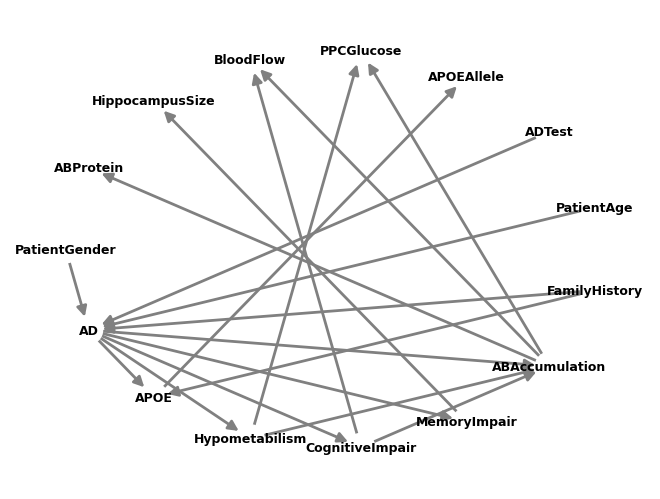

No. of Nodes:  15
No. of Edges:  19


In [28]:
max_samples = n_samples
show_network(model_gt, "Ground_Truth")

# Algorithm I

In [29]:
def make_idiot_bayes_latent(Tr, idiot_features):
    df_with_missing = introduce_missing_data(Tr, idiot_features) 
    
    return df_with_missing


def relearn_latent_variables_with_gmm(Tr_incomplete, Te, latent_info, state_spaces):
    d_points = int(len(Te)*0.05)
    Tr_imputed = add_random_rows(Te, Tr_incomplete, num_rows=20)
    Tr_imputed = impute_missing_data(Tr_imputed, [f for f in latent_info])
    Tr_with_clusters = add_latent_features_via_clustering(Tr_imputed, latent_info, state_spaces)
    
    return Tr_with_clusters


def learn_structure(Tr, algorithm_func, S, state_spaces):
    learned_structure = algorithm_func(Tr, S, state_spaces)
    
    return learned_structure
    

In [30]:
Tr, Te, Va = split_data(df_main)

### Introducing our latent variables 

**Cluster Label: AD**

*Latenet variable:* AD

*Explained by/Can be modeled from:* {PatientGender, FamilyHistory, PatientAge, ADTest}

*Why/Explanation:* The diagnosis or likelihood of AD is influenced by a combination of gender, genetic predisposition (family history), age, and specific diagnostic tests (ADTest). This mirrors real-world diagnostics where these factors are combined to assess the risk or presence of AD.

**Cluster Label: Amyloid Pathology**

*Latent Variable:* ABProtein

*Explained by/Can be modeled from:* {ABAccumulation, ADTest, BloodFlow}

*Why:* Amyloid pathology, characterized by the accumulation of amyloid plaques, is a hallmark of AD but is latent because it is typically confirmed through imaging or cerebrospinal fluid analysis. The accumulation of amyloid-beta (ABAccumulation), AD confirmation tests (ADTest), and cognitive impairment (CognitiveImpair) are observable indicators that can suggest the extent of amyloid pathology.

**Cluster Label: APOE Allele Status**

*Latent Variable:* APOE Allele

*Observable:* {FamilyHistory, ADTest, APOE, PatientGender}

*Why:* The presence of certain alleles of the APOE gene is a risk factor for AD, but it is a latent feature that is indirectly observed through genetic testing. Family history can indicate genetic predisposition, and the presence of AD can increase the likelihood of having a certain APOE allele. The APOE protein levels can also suggest the allele status.

**Cluster Label: Metabolic Dysfunction**

*Latent Variable:* Hypometabilism

*Observable:* {PPCGlucose, ADTest, BloodFlow}

*Why:* Metabolic dysfunction in the brain is a latent feature inferred from glucose metabolism in the posterior cingulate cortex (PPCGlucose), overall brain metabolism (Hypometabilism), and blood flow (BloodFlow), which are all indicators of metabolic health in neural tissues.

**Cluster Label: Cognitive Impairment**

*Latent Variable:* CognitiveImpair

*Observable:* {ADTest, MemoryImpair, BloodFlow, PPCGlucose}

*Why:* Cognitive impairment is often a latent feature that is inferred from neuropsychological assessments (ADTest), reports or tests of memory functions (MemoryImpair), and cerebral blood flow measurements (BloodFlow) which can reflect the brain's health and its capacity for cognitive functions.

In [31]:
informed_features = {
    'AD': ['PatientGender', 'FamilyHistory', 'PatientAge', 'ADTest'], 
    'Hypometabilism': ['PPCGlucose', 'ADTest', 'BloodFlow'], 
    'APOEAllele': ['FamilyHistory', 'ADTest', 'APOE', 'PatientGender'], 
    'ABProtein': ['ABAccumulation', 'ADTest', 'BloodFlow'],
    'CognitiveImpair': ['ADTest', 'MemoryImpair', 'BloodFlow', 'PPCGlucose']
}

def get_latent_features(data, strategy):
    if strategy == 'informed':
        features = informed_features
    elif strategy == 'random_3':
        features = ['AD'] + random.sample([col for col in data.columns if col != 'AD'], 3)
    elif strategy == 'random_6':
        features = ['AD'] + random.sample([col for col in data.columns if col != 'AD'], 6)
    elif strategy == 'random_9':
        features = ['AD'] + random.sample([col for col in data.columns if col != 'AD'], 9)
    else:
        raise ValueError("Unknown strategy: {}".format(strategy))
        
    return features


naive_strategies = ['informed', 'random_3', 'random_6', 'random_9']

In [32]:
latent_info = get_latent_features(Tr, 'informed')
latent_features = [f for f in latent_info]
Tr_incomplete = make_idiot_bayes_latent(Tr, latent_features)
Tr_incomplete.head()

PatientGender  FamilyHistory  PatientAge  ADTest  APOE  Hypometabilism  \
1194              0              1           1       1     1             NaN   
1466              0              1           3       1     1             NaN   
1855              0              0           1       1     1             NaN   
1591              1              0           0       1     1             NaN   
533               0              1           0       1     1             NaN   

      CognitiveImpair  MemoryImpair  ABAccumulation  HippocampusSize  \
1194              NaN             1               1                2   
1466              NaN             0               0                1   
1855              NaN             1               1                2   
1591              NaN             1               1                0   
533               NaN             0               1                3   

      APOEAllele  ABProtein  PPCGlucose  BloodFlow  AD  
1194         NaN        NaN           1          0 NaN  
1466         NaN        NaN           1          1 NaN  
1855         NaN        NaN           0          2 NaN  
1591         NaN        NaN           1          2 NaN  
533          NaN        NaN           0          2 NaN

In [33]:
missing_data_overview = show_missing(Tr_incomplete)
missing_data_overview

Missing Values  Percentage (%)
Hypometabilism              600           100.0
CognitiveImpair             600           100.0
APOEAllele                  600           100.0
ABProtein                   600           100.0
AD                          600           100.0
PatientGender                 0             0.0
FamilyHistory                 0             0.0
PatientAge                    0             0.0
ADTest                        0             0.0
APOE                          0             0.0
MemoryImpair                  0             0.0
ABAccumulation                0             0.0
HippocampusSize               0             0.0
PPCGlucose                    0             0.0
BloodFlow                     0             0.0

### Expectation Maximization with Gaussian Mixture Models

The different types of Mixture Models:   Spherical and diagonal are simpler and less computationally expensive, but they might not capture the structure of the data as well as tied or full.
Tied can be a good compromise between complexity and flexibility when the number of components is high, as it shares the same covariance matrix across components.
Full is the most flexible but also the most prone to overfitting, especially as the number of features increases. It requires a lot of data to estimate the parameters reliably.

We use the GMM that gives us the best BIC score given an unseen subset of the training data Tr.

### Re learning latent variables

In [34]:
num_rows = int(len(Tr)*0.05)
Tr_incomplete = add_random_rows(Te, Tr_incomplete, num_rows)
Tr_complete = relearn_latent_variables_with_gmm(Tr_incomplete, Te, latent_info, state_spaces)
Tr_complete.head()

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


PatientGender  FamilyHistory  PatientAge  ADTest  APOE  Hypometabilism  \
0              0              1           1       1     1               0   
1              0              1           3       1     1               0   
2              0              0           1       1     1               0   
3              1              0           0       1     1               0   
4              0              1           0       1     1               0   

   CognitiveImpair  MemoryImpair  ABAccumulation  HippocampusSize  APOEAllele  \
0                0             1               1                2           0   
1                0             0               0                1           0   
2                0             1               1                2           0   
3                0             1               1                0           0   
4                0             0               1                3           0   

   ABProtein  PPCGlucose  BloodFlow  AD  
0          0           1          0   0  
1          0           1          1   0  
2          0           0          2   0  
3          0           1          2   0  
4          0           0          2   0

### Representing Latent Variables: Naive Bayes Models

In [35]:
Tr_idiot = Tr_complete[[f for f in latent_info.keys()]]  
Tr_idiot.tail(12)

AD  Hypometabilism  APOEAllele  ABProtein  CognitiveImpair
638   0               1           0          0                0
639   1               1           0          0                1
640   0               1           0          0                0
641   1               1           0          1                1
642   1               0           0          0                0
643   1               1           1          1                1
644   0               1           0          1                0
645   0               0           0          0                1
646   0               1           0          1                0
647   0               1           0          0                0
648   0               1           0          0                0
649   0               1           1          1                0

### Structure Learning between Latent Variables: Initial Structures

In [36]:
def control_structure(df):
    predefined_edges = [
        ('PatientGender', 'AD'), ('FamilyHistory', 'AD'), ('PatientAge', 'AD'), ('ADTest', 'AD'),
        ('FamilyHistory', 'APOE'), ('AD', 'APOE'), ('AD', 'Hypometabilism'), ('AD', 'CognitiveImpair'), ('AD', 'MemoryImpair'),
        ('AD', 'ABAccumulation'), ('CognitiveImpair', 'ABAccumulation'), ('Hypometabilism', 'ABAccumulation'),
        ('MemoryImpair', 'HippocampusSize'), ('APOE', 'APOEAllele'), ('ABAccumulation', 'ABProtein'), ('ABAccumulation', 'PPCGlucose'), 
        ('Hypometabilism', 'PPCGlucose'), ('ABAccumulation', 'BloodFlow'), ('CognitiveImpair', 'BloodFlow')
    ]

    applicable_edges = [edge for edge in predefined_edges if edge[0] in df.columns and edge[1] in df.columns]
    S = DAG()
    S.add_nodes_from(df.columns)  # Ensure that all columns are added as nodes
    S.add_edges_from(applicable_edges)
    
    if not nx.is_directed_acyclic_graph(S):
        raise ValueError("The control structure is not a DAG.")
    return S


def tree_structure(df):
    ts = TreeSearch(df, root_node=None)
    tree = ts.estimate(estimator_type="chow-liu")
    
    S = DAG()
    
    # Check if the tree has the same variables as the dataset
    if set(tree.nodes()) != set(df.columns):
        S.add_nodes_from(df.columns)
        S.add_edges_from(tree.edges())
        return S
        print("The learned tree does not contain the same variables as the data set.")

        
    S.add_edges_from(tree.edges())
    
    return S


def tan_structure(df):
    Tr, Te, Va = split_data(df, 0.3, 0.2)
    
    best_bic = float('inf')
    best_structure = None
    S = DAG()

    for var in df.columns:
        ts = TreeSearch(Tr)
        if var == ts.root_node:
            continue

        try:
            tree = ts.estimate(estimator_type='tan', class_node=var)

            bic_calculator = BicScore(Va)
            bic_score = bic_calculator.score(tree)

            if bic_score < best_bic:
                best_tree = tree
                best_bic = bic_score

        except ValueError as e:
            # If a ValueError is raised, skip this iteration and continue with the next
            print(f"Skipping TAN structure learning for class node '{var}': {e}")
            continue

    S.add_nodes_from(df.columns)
    S.add_edges_from(best_tree.edges())
    return S



def graph_structure(df):
    S = structure_learning(df)
    return S



def random_structure(df):
    num_edges = len(df.columns) * 2  
    random_dag_structure = random_dag(list(df.columns), num_edges)
    random_structure_edges = list(random_dag_structure.edges())
    
    S = DAG()
    S.add_nodes_from(df.columns)  
    S.add_edges_from(random_structure_edges)
    
    if not nx.is_directed_acyclic_graph(S):
        raise ValueError("The random structure is not a DAG.")
    return S



all_structures = {
    'none': None,
    'control': lambda df: control_structure(df),
    'tree': lambda df: tree_structure(df),
    'tan': lambda df: tan_structure(df),
    'hcs': lambda df: graph_structure(df),  
    'random': lambda df: random_structure(df)
}

### Structure Learning between Latent Variables: Hill Climb Search

In [37]:
S = tan_structure(Tr_idiot)
M = structure_learning(Tr_idiot, S, state_spaces)

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


### Parameter Estimation: Marginal Likelihood Estimation

The nodes of our model do not have CPDs. We will use the data and parameter estimation to add the necessary CPDs to our model, so that we can calculate the KL Divergence between it and the ground truth model.

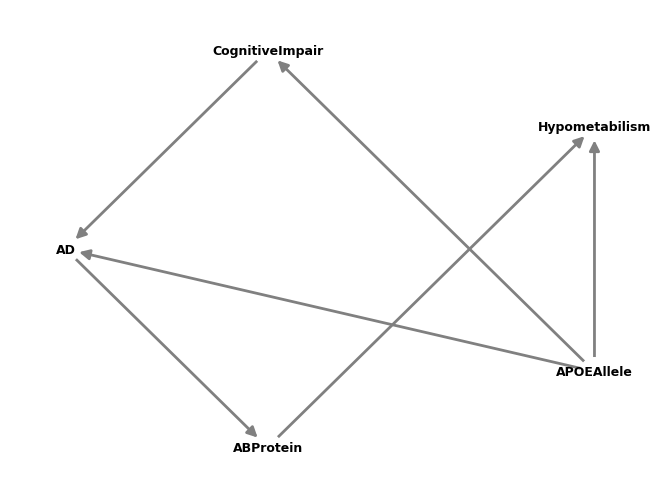

No. of Nodes:  5
No. of Edges:  6


In [38]:
M = parameter_estimation(M, Tr_idiot, state_spaces, True)

### KL Divergence on evidence Va

We will be measuring the difference/similarity between the two probability distributions using the Kullback-Leibler (KL) divergence.

- \( P \) will be the true underlying distribution represented by the given Bayesian network `model_gt` (gt = ground truth), and
- \( Q \) will be the distribution learned from the data by `bn_model` using our algorithm.

So the KL divergence \( KL(P || Q) \) will quantify how much the learned `bn_model` differs from the true `model_gt`. A lower KL Divergence value will indicate more similarity between the two.

    NB: KL divergence is not symmetric, so  KL(P || Q)  is not the same as  KL(Q || P) .

In [39]:
kl = calculate_kl_on_evidence(M, model_gt, Va)

KL Divergence Value:  0.3351931325391737


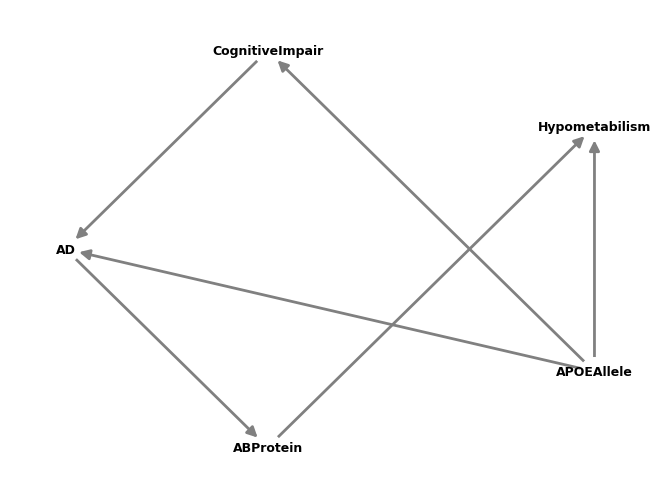

No. of Nodes:  5
No. of Edges:  6


In [40]:
show_network(M, "Learned_Model M")

In [41]:
source = get_dot(M)
print(source)

strict digraph  {
AD;
ABProtein;
APOEAllele;
Hypometabilism;
CognitiveImpair;
AD -> ABProtein;
ABProtein -> Hypometabilism;
APOEAllele -> Hypometabilism;
APOEAllele -> CognitiveImpair;
APOEAllele -> AD;
CognitiveImpair -> AD;
}



C:\Users\delis\AppData\Local\Temp\ipykernel_22424\3250311961.py:3: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pydot_graph = nx.drawing.nx_pydot.to_pydot(graph)


In [42]:
source.render("learned_graph_image", format="png")

'learned_graph_image.png'

Interpretation:

Larger KL Divergence: The KL divergence measures the dissimilarity between two probability distributions. A larger KL divergence indicates that the probability distribution of the marginalized model differs more significantly from the original model in terms of how it assigns probabilities to different events or states of the variables.

Information Loss: Marginalization involves integrating or summing out certain variables, which can lead to a loss of information. In your case, when you marginalized the "Model_" variables, you essentially removed them from consideration, and this may have resulted in the loss of important information or dependencies present in those variables.

Reduced Model Complexity: Marginalization simplifies the model by reducing the number of variables. While this can be useful for simplification and faster computation, it may also result in a less accurate representation of the underlying probabilistic relationships.

Impact on Divergence: The impact of marginalization on KL divergence depends on the specific variables being marginalized and their relationships with other variables in the model. If the variables being marginalized were important for capturing the joint distribution accurately, removing them can lead to a larger KL divergence.

### Helpers

# Multiple No. of Samples

In [43]:
start_time = time.time()

In [44]:
max_samples = 3000
start = int(max_samples/15)
inc = start
n_samples_values = np.arange(start, max_samples+1, inc)
missing_rate = 1.0
num_candidate_structures = 4
alpha = 1
max_edges = int((len(latent_info) - 1) * alpha)
iterations = 4
tabu_size = 200
num_restarts = 3
max_edges

4

In [45]:
naive_strategies = ['informed']

all_structures = {
    'none': None,
    'informed': lambda df: control_structure(df),
    'tree': lambda df: tree_structure(df),
    'tan': lambda df: tan_structure(df),
    'random': lambda df: random_structure(df)
}

In [46]:
def run_algorithm(algorithm_func, results_dict, n_samples_values, max_retries=20):
    for latent_info, structures in results_dict.items():
        for initial_S_key in structures:
            results_dict[latent_info][initial_S_key]['kl_divergence'].clear()
            results_dict[latent_info][initial_S_key]['num_edges'].clear()
            results_dict[latent_info][initial_S_key]['num_nodes'].clear()
            results_dict[latent_info][initial_S_key]['edges'].clear()

    best_models_per_latent_info = {latent: {'kl_divergence': float('inf')} for latent in naive_strategies}
    model_gt = ground_truth()

    for n_samples in n_samples_values:
        for latent_info in naive_strategies:
            for initial_S_key, initial_S_func in all_structures.items():
                retries = 0
                successful_trials = 0
                while (retries < max_retries and successful_trials == 0):
                    try:
                        print(f'[ {n_samples}, {latent_info}, {initial_S_key} ] : Try {retries+1} out of {max_retries} with {successful_trials} Successful_trials.')
                        # Generate synthetic data
                        D, _ = generate_synthetic_data(model_gt, n_samples)
                        state_spaces = get_state_space_sizes(D)
                        Tr, Te, Va = split_data(D)
                                                
                        # Remove latent info columns                        
                        latent = get_latent_features(Tr, latent_info)
                        latent_features = [f for f in latent]
                        Tr_incomplete = make_idiot_bayes_latent(Tr, latent_features)

                        # Relearn latent variables using GMM
                        num_rows = int(len(Tr)*0.05)
                        Tr_incomplete = add_random_rows(Te, Tr_incomplete, num_rows)
                        Tr_complete = relearn_latent_variables_with_gmm(Tr_incomplete, Te, latent, state_spaces)
                        Tr = Tr_complete[[f for f in latent.keys()]]                         

                        # Learn the structure between latent variables as a Bayesian Network
                        S = initial_S_func(Tr) if initial_S_func else None
                        M = learn_structure(Tr, algorithm_func, S, state_spaces)
                        M = parameter_estimation_dp(M, Tr, state_spaces)

                        # Calculate the KL divergence on Validation Set
                        kl = calculate_kl_on_evidence(M, model_gt, Va)

                        # Check for negative KL divergence
                        if kl < 0:
                            print(f"Negative KL divergence encountered for n_samples={n_samples} with {latent_info} and {initial_S_key}. Retrying...")
                            continue  # Retry without incrementing the retries counter
                            
                        if kl < best_models_per_latent_info[latent_info]['kl_divergence']:
                            best_models_per_latent_info[latent_info] = {
                                'model': M,
                                'kl_divergence': kl,
                                'initial_structure_key': initial_S_key,
                                'num_edges': len(M.edges()),
                                'n_samples': n_samples
                            }

                        num_edges = len(M.edges())
                        num_nodes = len(M.nodes())

                        # Store the results
                        results_dict[latent_info][initial_S_key]['kl_divergence'].append(kl)
                        results_dict[latent_info][initial_S_key]['num_edges'].append(num_edges)
                        results_dict[latent_info][initial_S_key]['num_nodes'].append(num_nodes)
                        results_dict[latent_info][initial_S_key]['edges'].append(list(M.edges()))

                        successful_trials += 1
                        retries = 0
                        print("Successful.")
                        break

                    except Exception as e:
                        print(f"An error occurred for n_samples={n_samples} with {latent_info} and {initial_S_key}: {str(e)}")
                        retries += 1
                        if retries == max_retries:
                            print(f"Max retries reached for n_samples={n_samples} with {latent_info} and {initial_S_key}. Moving to the next iteration.")
                            results_dict[latent_info][initial_S_key]['kl_divergence'].append(None)
                            results_dict[latent_info][initial_S_key]['num_edges'].append(None)
                            results_dict[latent_info][initial_S_key]['num_nodes'].append(None)
                            results_dict[latent_info][initial_S_key]['edges'].append(None)

    return best_models_per_latent_info


In [47]:
models_to_run = {
    "Basic HCS": lambda df, S, state_spaces: structure_learning(df, S, state_spaces),
    "Ensemble (MI Ranking)": lambda df, S, state_spaces: structure_learning_bma(df, S, state_spaces),
    "Ensemble II (+ Random Restarts + BIC Ranking)": lambda df, S, state_spaces: structure_learning_bma_rr(df, S, state_spaces),
    "Tabu Search on HCS": lambda df, S, state_spaces: structure_learning_tabu(df, S, state_spaces),
    "Tabu Search (Limited Edges)": lambda df, S, state_spaces: structure_learning_tabu_lim(df, S, state_spaces),
    "Ensemble III (+ Tabu Search + Limited Edges)": lambda df, S, state_spaces: structure_learning_ensemble(df, S, state_spaces)
}

results_placeholder = {
    'kl_divergence': [],
    'num_edges': [],
    'num_nodes': [],
    'edges': [],
}

results = {
    algo: {
        latent_info: {
            initial_S: copy.deepcopy(results_placeholder) for initial_S in all_structures.keys()
        } for latent_info in naive_strategies
    } for algo in models_to_run.keys()
}


In [48]:
alg_models = run_algorithm(models_to_run['Basic HCS'], results['Basic HCS'], n_samples_values)
alg_results = results['Basic HCS']

[ 200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5354131312615728
Successful.
[ 200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.029483853214207465
Successful.
[ 200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  7.094978727618812
Successful.
[ 200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.084609288952422
Successful.
[ 200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  6.762657972299306
Successful.
[ 400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  8.632490704266687
Successful.
[ 400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  5.3496935346209415
Successful.
[ 400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.48120527600011165
Successful.
[ 400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  7.703078835141409
Successful.
[ 400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5414251631144212
Successful.
[ 600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.40581920747116446
Successful.
[ 600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  6.6275121848603575
Successful.
[ 600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5259584000601728
Successful.
[ 600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.09641388044264992
Successful.
[ 600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4851415871417061
Successful.
[ 800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.550471134148603
Successful.
[ 800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5105156181539442
Successful.
[ 800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4966800821368618
Successful.
[ 800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.47916825884583797
Successful.
[ 800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.47936028230284367
Successful.
[ 1000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.11454809601001227
Successful.
[ 1000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  7.813308490493757
Successful.
[ 1000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5345153463617174
Successful.
[ 1000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.44718418621548495
Successful.
[ 1000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  7.126234750814276
Successful.
[ 1200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4589578995023412
Successful.
[ 1200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5055527933638592
Successful.
[ 1200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.495475725168913
Successful.
[ 1200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5018443926689862
Successful.
[ 1200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4697558706068259
Successful.
[ 1400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5185013286558282
Successful.
[ 1400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4534993281131048
Successful.
[ 1400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5249535522440064
Successful.
[ 1400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.46514062992050337
Successful.
[ 1400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.49173379496912095
Successful.
[ 1600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4954305133872048
Successful.
[ 1600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4413427080082137
Successful.
[ 1600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5168121170713417
Successful.
[ 1600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5157972942215217
Successful.
[ 1600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5333879180546357
Successful.
[ 1800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.49514055728233675
Successful.
[ 1800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4963740205939632
Successful.
[ 1800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.46460121987917513
Successful.
[ 1800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5437957682918594
Successful.
[ 1800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.518170084672937
Successful.
[ 2000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4946943308152619
Successful.
[ 2000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.49851951644556664
Successful.
[ 2000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5163430426597977
Successful.
[ 2000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.49868573704115143
Successful.
[ 2000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.47067726535317955
Successful.
[ 2200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5023852141741832
Successful.
[ 2200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4841633716899514
Successful.
[ 2200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5091662425925834
Successful.
[ 2200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.49128108665143716
Successful.
[ 2200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.48879594941894994
Successful.
[ 2400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4741394538756521
Successful.
[ 2400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5017375174425563
Successful.
[ 2400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.49769544101782087
Successful.
[ 2400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5376698456145189
Successful.
[ 2400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4857871106929338
Successful.
[ 2600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5053164063014265
Successful.
[ 2600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4833453216638726
Successful.
[ 2600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5218068333105232
Successful.
[ 2600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.47563389049965366
Successful.
[ 2600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4568581805997078
Successful.
[ 2800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4719712200632878
Successful.
[ 2800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5080323059890343
Successful.
[ 2800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5065843103577653
Successful.
[ 2800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'APOEAllele': Root node: APOEAllele and class node: APOEAllele are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.46069196801524676
Successful.
[ 2800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.483895497996966
Successful.
[ 3000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5000564962360112
Successful.
[ 3000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.5186309976726308
Successful.
[ 3000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.47134302504978953
Successful.
[ 3000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4320515150723961
Successful.
[ 3000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
KL Divergence Value:  0.4898997247225343
Successful.


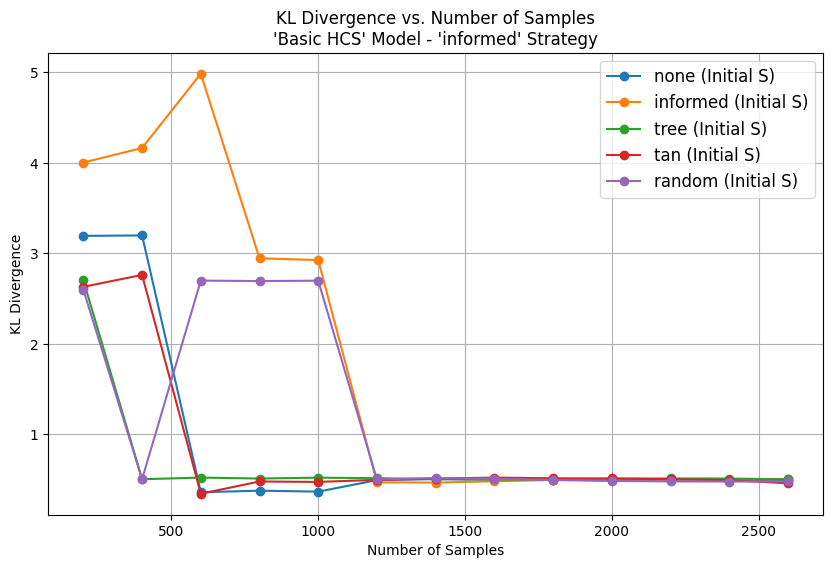

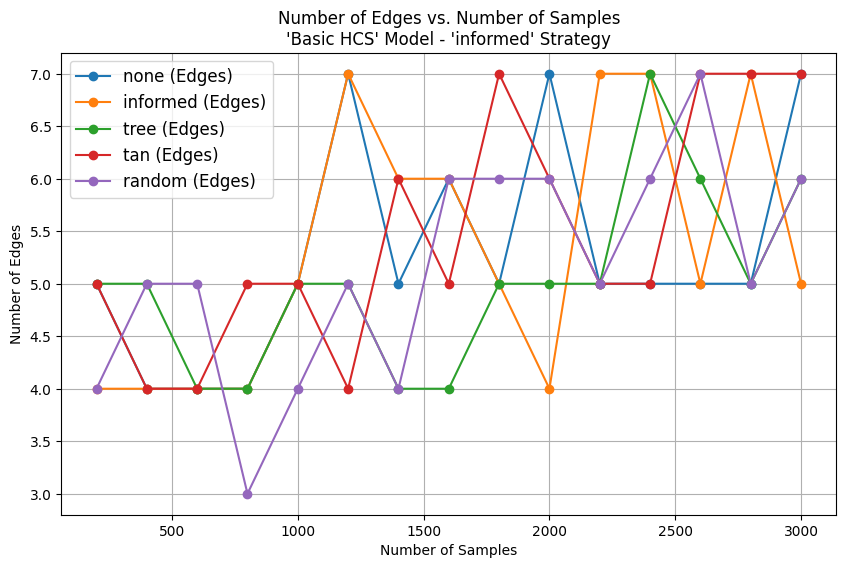

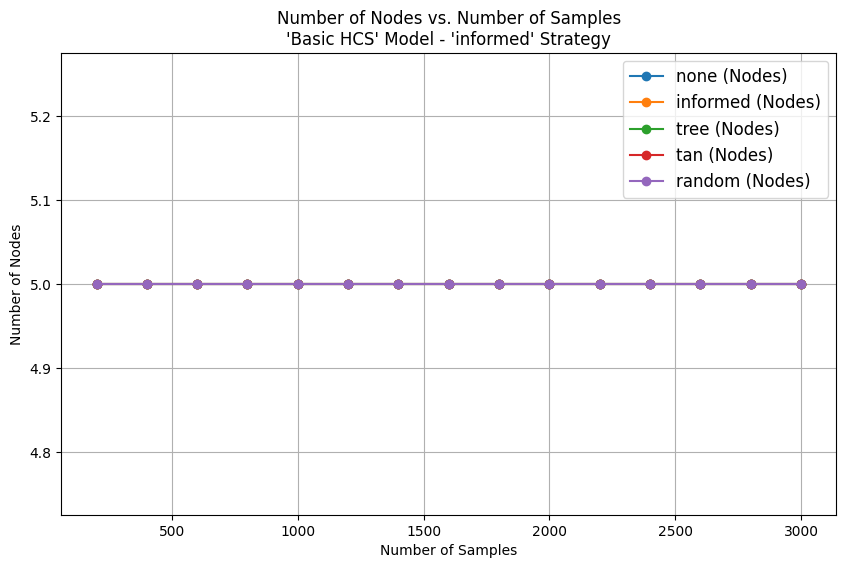

In [49]:
plot_algo_results(results, n_samples_values, 'Basic HCS', 'informed', max_samples)

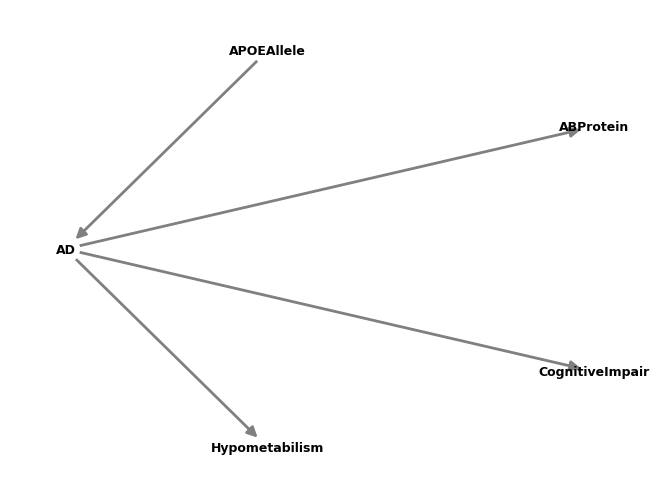

No. of Nodes:  5
No. of Edges:  4


In [50]:
show_network(alg_models['informed']['model'], "Final Basic HCS BN Model")

# BMA

Performing structure averaging across candidate Bayesian network models involves combining the individual candidate models into a single averaged structure. The goal is to find a consensus structure that represents the collective knowledge of the candidate models. One common approach is to compute the "voting" or "consensus" edges among the candidates. We can also consider ranking the edges by their Mutual Information values.

In [51]:
def compute_mutual_information(data, X, Y):
    """Compute mutual information between two columns X and Y in data."""
    return mutual_info_regression(data[[X]], data[Y])[0]

def rank_edges_by_mutual_information(data, edges):
    """Rank edges by mutual information."""
    edge_scores = {edge: compute_mutual_information(data, edge[0], edge[1]) for edge in edges}
    ranked_edges = sorted(edge_scores.items(), key=lambda x: -x[1])
    return ranked_edges

def perform_structure_averaging_mi(candidate_models, df, state_spaces, max_edges=50):
    """ToDO:  rank candidate models using BIC on testing set Te of dataset D
        edges from top 2 candidate models should be ranked more by a factor of 2
    """
    Tr, Te, Va = split_data(df, 0.3, 0.1)
    
    models = []
    for model in candidate_models:
        model = BayesianNetwork(model)
        bn_model = parameter_estimation_max(model, Tr, state_spaces)
        models.append(bn_model)
    
    edges = []
    for model in models:
        for edge in model.edges():
            edges.append(edge)

    ranked_edges = rank_edges_by_mutual_information(Tr, edges)
    edge_adder = EdgeAdder(ranked_edges, max_edges)
    final_structure = edge_adder.add_edges()
    
    return final_structure


In [52]:
def structure_learning_bma(df, S, state_spaces, num_candidate_structures=num_candidate_structures):
    num_bands = 3
    
    band_size = len(df) // num_bands
    bands = [df.iloc[i*band_size:(i+1)*band_size] for i in range(num_bands)]
    candidate_models = []

    print(f"Generating {num_candidate_structures} candidate structures for {num_bands} bands...")
    for band in bands:
        for n in range(num_candidate_structures):
            candidate_structure = structure_learning(band, S)
            if nx.is_directed_acyclic_graph(candidate_structure):
                candidate_models.append(candidate_structure)
                
    print(f"Generated {len(candidate_models)} candidate structures.")

    averaged_structure = perform_structure_averaging_mi(candidate_models, df, state_spaces, max_edges=len(df.columns)*3)

    print("Ensemble (MI Ranking)")

    network = BayesianNetwork(averaged_structure.edges())

    return network

In [53]:
bma_models = run_algorithm(models_to_run['Ensemble (MI Ranking)'], results['Ensemble (MI Ranking)'], n_samples_values)
bma_results = results['Ensemble (MI Ranking)']

[ 200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  -0.06398781819420213
Negative KL divergence encountered for n_samples=200 with informed and none. Retrying...
[ 200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  9.334422869829156
Successful.
[ 200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  -0.005587563616166117
Negative KL divergence encountered for n_samples=200 with informed and informed. Retrying...
[ 200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5802762499372697
Successful.
[ 200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.1494722825669884
Successful.
[ 200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.46330423650028524
Successful.
[ 200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.09704148433191712
Successful.
[ 400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.47292226981726937
Successful.
[ 400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  8.64972905594529
Successful.
[ 400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5019485349193653
Successful.
[ 400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5201661929472314
Successful.
[ 400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.013900792136537976
Successful.
[ 600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5131775194077438
Successful.
[ 600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  7.417487983395258
Successful.
[ 600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5222800842458111
Successful.
[ 600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'ABProtein': Root node: ABProtein and class node: ABProtein are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5297848811874051
Successful.
[ 600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5888525554286909
Successful.
[ 800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5413395278304552
Successful.
[ 800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5211134450456825
Successful.
[ 800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5187677048718053
Successful.
[ 800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5006133823564238
Successful.
[ 800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5044182900131714
Successful.
[ 1000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.46928369859050045
Successful.
[ 1000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5108552537427726
Successful.
[ 1000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.47357631921360877
Successful.
[ 1000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.48883783519195256
Successful.
[ 1000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.4797020217979362
Successful.
[ 1200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.4674583563128205
Successful.
[ 1200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.49279321439325074
Successful.
[ 1200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5420720610767041
Successful.
[ 1200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.4913989365695926
Successful.
[ 1200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.506518995811073
Successful.
[ 1400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5137527461528097
Successful.
[ 1400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.46483473717040263
Successful.
[ 1400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.44661046433254886
Successful.
[ 1400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.40510750467479534
Successful.
[ 1400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.47116174676867384
Successful.
[ 1600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.49378809074703195
Successful.
[ 1600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5141477237009132
Successful.
[ 1600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5080076777723149
Successful.
[ 1600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.4707975103139601
Successful.
[ 1600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.48889989599596456
Successful.
[ 1800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.4965518124401908
Successful.
[ 1800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.48288317127633806
Successful.
[ 1800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.479593132426154
Successful.
[ 1800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.4501125629348508
Successful.
[ 1800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.4685988486167415
Successful.
[ 2000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5331258495972615
Successful.
[ 2000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.509525275662353
Successful.
[ 2000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.502552601361262
Successful.
[ 2000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5144252751534962
Successful.
[ 2000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.42917035718301133
Successful.
[ 2200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.502960296466297
Successful.
[ 2200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5200566148438316
Successful.
[ 2200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5351817892412372
Successful.
[ 2200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'ABProtein': Root node: ABProtein and class node: ABProtein are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.47549685546816145
Successful.
[ 2200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5073529845714573
Successful.
[ 2400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5377945080136917
Successful.
[ 2400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.4837086632302885
Successful.
[ 2400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.49590351637418395
Successful.
[ 2400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5116119047331096
Successful.
[ 2400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.49349404368612215
Successful.
[ 2600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.45179091564837837
Successful.
[ 2600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5397974538416818
Successful.
[ 2600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.44652273308189777
Successful.
[ 2600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'APOEAllele': Root node: APOEAllele and class node: APOEAllele are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5110387819819515
Successful.
[ 2600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.489420466016468
Successful.
[ 2800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.517155003237824
Successful.
[ 2800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5143025251241368
Successful.
[ 2800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.47525420422802916
Successful.
[ 2800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5165067712980881
Successful.
[ 2800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5226875016835377
Successful.
[ 3000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.5523202288567894
Successful.
[ 3000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.47974034860164344
Successful.
[ 3000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.48311344104479775
Successful.
[ 3000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'APOEAllele': Root node: APOEAllele and class node: APOEAllele are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.46082591937813516
Successful.
[ 3000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble (MI Ranking)
KL Divergence Value:  0.4733174920905052
Successful.


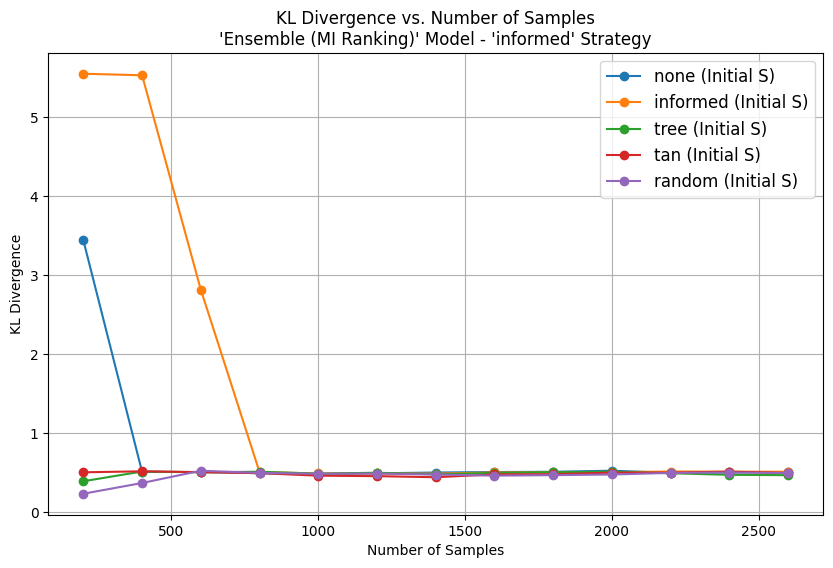

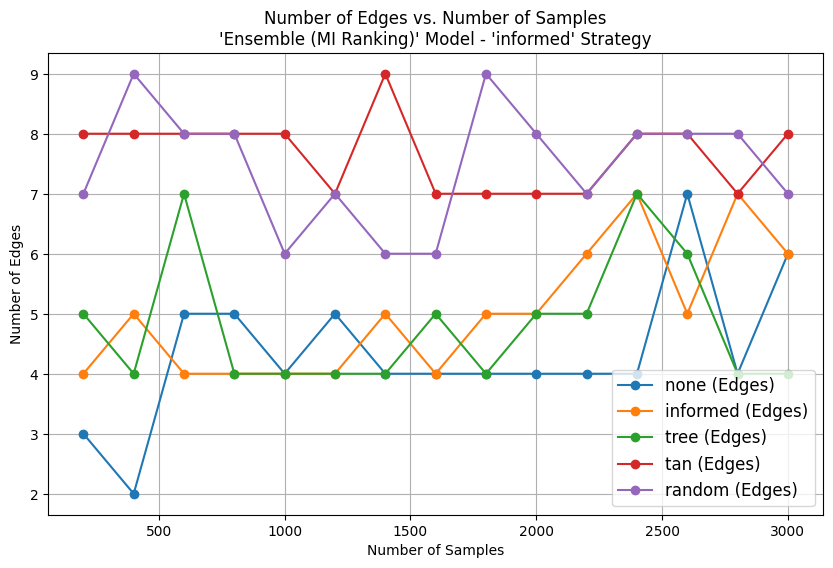

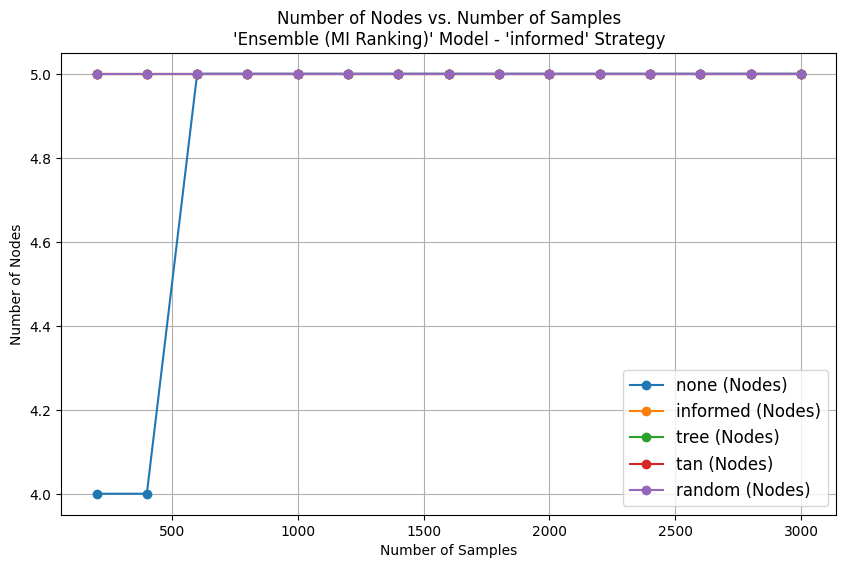

In [54]:
plot_algo_results(results, n_samples_values, 'Ensemble (MI Ranking)', 'informed', max_samples)

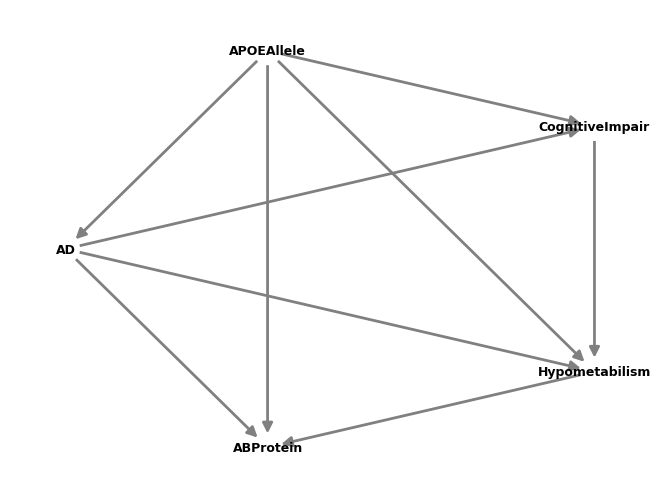

No. of Nodes:  5
No. of Edges:  9


In [55]:
show_network(bma_models['informed']['model'], "Final BMA I [Ensemble (MI Ranking)] BN Model")

# BMA + Restart

In [56]:
def compute_bic_scores(models, data):
    """Compute BIC scores for a list of models."""
    bic_calculator = BicScore(data)
    model_scores = [(model, bic_calculator.score(model)) for model in models]
    sorted_models = sorted(model_scores, key=lambda x: x[1])
    return sorted_models

def perform_structure_averaging_models(candidate_models, df, state_spaces, max_edges=50):
    Tr, Te, Va = split_data(df, 0.2, 0.2)
    
    # Compute BIC scores for each candidate model on the testing set
    candidate_bayesian_models = []
    for model in candidate_models:
        model = BayesianNetwork(model)
        bn_model = parameter_estimation_max(model, Va, state_spaces)
        candidate_bayesian_models.append(bn_model)
        
    sorted_models_by_bic = compute_bic_scores(candidate_bayesian_models, Va)
    
    # Rank edges by mutual information using the validation set
    edges = []
    for model, _ in sorted_models_by_bic:
        edges.extend(model.edges())
    ranked_edges = rank_edges_by_mutual_information(Te, edges)

    # Double the score of edges from the top 2 models
    top_2_models = [model for model, _ in sorted_models_by_bic[:2]]
    for index, (edge, score) in enumerate(ranked_edges):
        if edge in top_2_models[0].edges() or edge in top_2_models[1].edges():
            ranked_edges[index] = (edge, score * 2)

    ranked_edges.sort(key=lambda x: -x[1])
    edge_adder = EdgeAdder(ranked_edges, max_edges)
    final_structure = edge_adder.add_edges()
    
    return final_structure

In [57]:
def hcs_rr_bands(df, S, state_spaces, num_candidate_structures, num_bands = 3):
    min_edges = len(df.columns)
    
    band_size = len(df) // num_bands
    bands = [df.iloc[i*band_size:(i+1)*band_size] for i in range(num_bands)]
    candidate_models = []

    print(f"Generating {num_candidate_structures} candidate structures for {num_bands} bands...")
    for band in bands:
        band = add_noise_to_band(band, state_spaces, 'gaussian')
        for n in range(num_candidate_structures):
            if n < num_candidate_structures / 2:
                candidate_structure = structure_learning(band, S)
            else:
                candidate_structure = random_dag(df.columns, min_edges)
            if nx.is_directed_acyclic_graph(candidate_structure):
                candidate_models.append(candidate_structure)
    print(f"Generated {len(candidate_models)} candidate structures.")
    
    return candidate_models


def structure_learning_bma_rr(df, S, state_spaces, num_candidate_structures=num_candidate_structures):
    candidate_models = hcs_rr_bands(df, S, state_spaces, num_candidate_structures)

    averaged_structure = perform_structure_averaging_models(candidate_models, df, state_spaces, max_edges=len(df.columns)*3)

    network = BayesianNetwork(averaged_structure.edges())
    
    print("Ensemble II (+ Random Restarts + BIC Ranking)")

    return network

In [58]:
bma_prob_model = run_algorithm(models_to_run['Ensemble II (+ Random Restarts + BIC Ranking)'], results['Ensemble II (+ Random Restarts + BIC Ranking)'], n_samples_values)
bma_prob_results = results['Ensemble II (+ Random Restarts + BIC Ranking)']

[ 200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  4.4873923899197985
Successful.
[ 200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.09311670357088123
Successful.
[ 200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  8.141100812585886
Successful.
[ 200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.010601307843865053
Successful.
[ 200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.03735193814119732
Successful.
[ 400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.42902591565539144
Successful.
[ 400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  8.37213858915648
Successful.
[ 400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5520604622571776
Successful.
[ 400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.07891502213426194
Successful.
[ 400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4849884895230104
Successful.
[ 600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5883332453485488
Successful.
[ 600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.46226636651578074
Successful.
[ 600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4839624498572936
Successful.
[ 600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5121273095252868
Successful.
[ 600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5061350752399051
Successful.
[ 800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5602734079745169
Successful.
[ 800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.44218736120550184
Successful.
[ 800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4919079018270514
Successful.
[ 800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5145233984568802
Successful.
[ 800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4913782652601487
Successful.
[ 1000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5233078820505007
Successful.
[ 1000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5129697981460928
Successful.
[ 1000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5057269741829548
Successful.
[ 1000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5601471033166283
Successful.
[ 1000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.42548156582896307
Successful.
[ 1200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5159786173553842
Successful.
[ 1200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5105663889016683
Successful.
[ 1200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4772160669932977
Successful.
[ 1200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4737751726928819
Successful.
[ 1200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.45615027767495403
Successful.
[ 1400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4400119507249417
Successful.
[ 1400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4687627851893978
Successful.
[ 1400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.46350413450279665
Successful.
[ 1400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'ABProtein': Root node: ABProtein and class node: ABProtein are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5086558280233581
Successful.
[ 1400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.44826206199329843
Successful.
[ 1600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5095102142708866
Successful.
[ 1600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4873527917730457
Successful.
[ 1600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4465617088554475
Successful.
[ 1600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4607761018780779
Successful.
[ 1600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4400216051701199
Successful.
[ 1800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5238620295667207
Successful.
[ 1800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.48216479856588557
Successful.
[ 1800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4904089094757799
Successful.
[ 1800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5172498364939923
Successful.
[ 1800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4781982567983647
Successful.
[ 2000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.48619478753451395
Successful.
[ 2000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5367575778295358
Successful.
[ 2000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5410931070351954
Successful.
[ 2000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4899329128210626
Successful.
[ 2000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5269574569582116
Successful.
[ 2200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4461897266045696
Successful.
[ 2200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.49418639486927696
Successful.
[ 2200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.49023411251222465
Successful.
[ 2200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4903191599781166
Successful.
[ 2200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5030999251886931
Successful.
[ 2400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4814392778297508
Successful.
[ 2400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4475571979351118
Successful.
[ 2400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5222270321189135
Successful.
[ 2400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'APOEAllele': Root node: APOEAllele and class node: APOEAllele are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4727993101651639
Successful.
[ 2400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4714810828173196
Successful.
[ 2600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4565213105963772
Successful.
[ 2600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.48916646580352907
Successful.
[ 2600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5091482578886976
Successful.
[ 2600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4703305497061833
Successful.
[ 2600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.40357516770741814
Successful.
[ 2800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.48353210861461
Successful.
[ 2800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5083657481077151
Successful.
[ 2800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5033034188641625
Successful.
[ 2800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5323408007767769
Successful.
[ 2800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4945741046062436
Successful.
[ 3000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.49043797625130775
Successful.
[ 3000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4898053354014904
Successful.
[ 3000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4832477691433618
Successful.
[ 3000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.4662893283643019
Successful.
[ 3000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.
Ensemble II (+ Random Restarts + BIC Ranking)
KL Divergence Value:  0.5716276401614216
Successful.


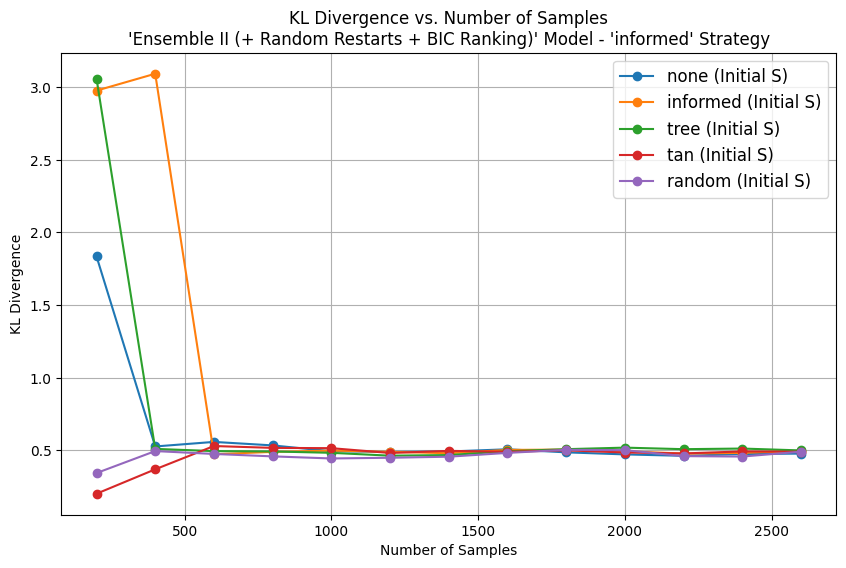

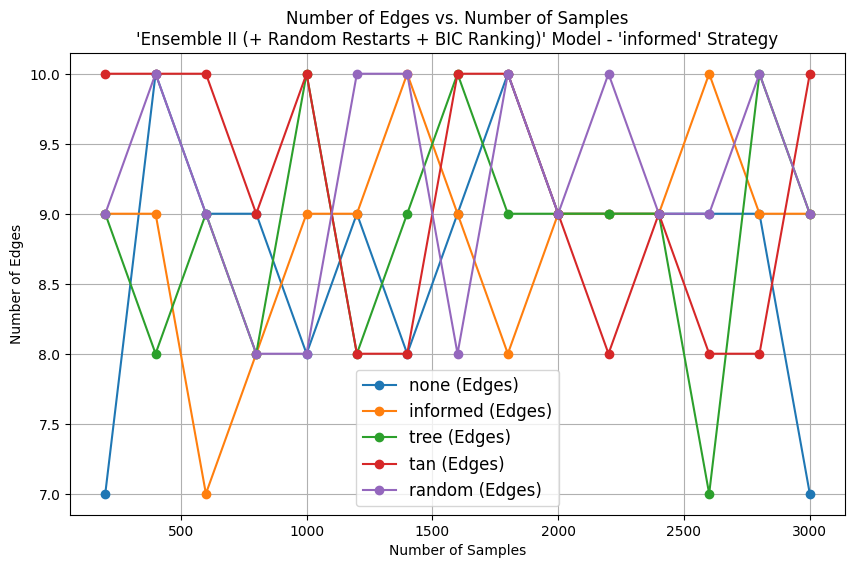

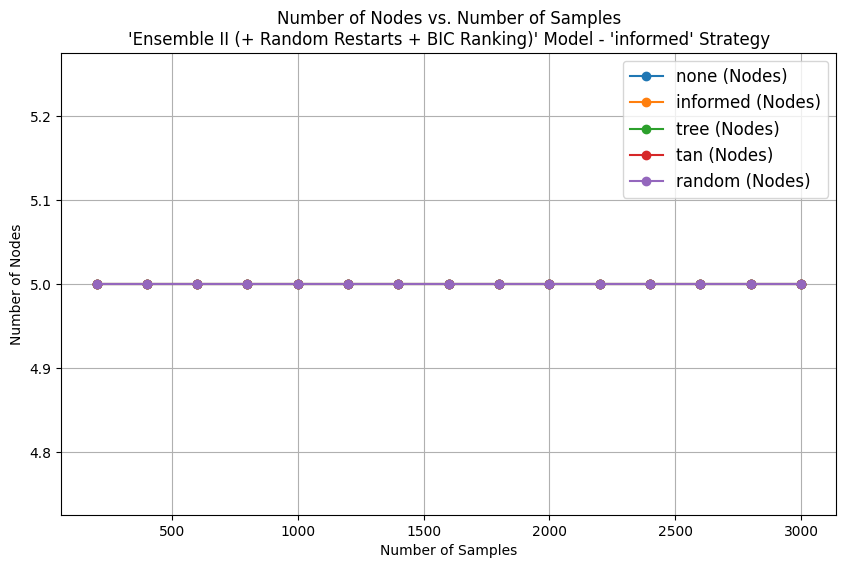

In [59]:
plot_algo_results(results, n_samples_values, 'Ensemble II (+ Random Restarts + BIC Ranking)', 'informed', max_samples)

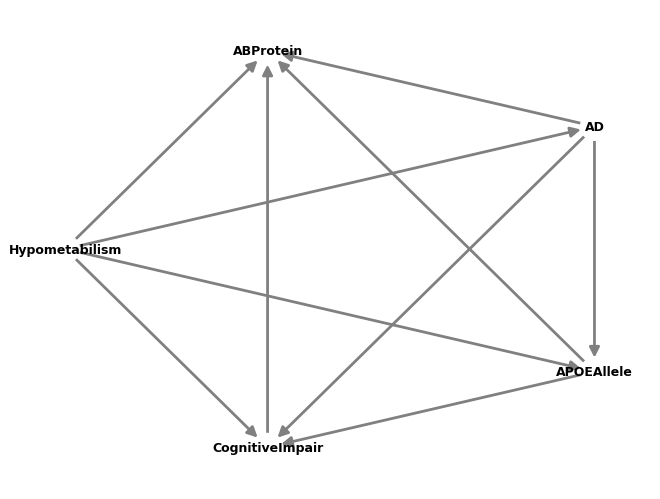

No. of Nodes:  5
No. of Edges:  10


In [60]:
show_network(bma_prob_model['informed']['model'], f"Final BMA RR [Ensemble II (+ Random Restarts + BIC Ranking)] BN Model")

# Algo Limit

Completeness, in the sense of the graph being fully connected, is not required. Here's why:

*Nature of Bayesian Networks*: Bayesian networks represent joint probability distributions over a set of variables. The absence of an edge between two nodes implies a conditional independence given the parents of the nodes. So, only adding edges that exist in the true underlying model is crucial to accurately representing the joint distribution.

*Avoiding Overfitting*: By adding unnecessary edges (making the graph more complete), we risk overfitting to the observed data. Overfitting can make your model poorly generalize to new, unseen data. It may also introduce spurious relationships that don't actually exist in the ground truth or in the underlying system.

*Interpretability and Simplicity*: One of the advantages of Bayesian networks is their interpretability. A simpler graph with fewer edges is often more interpretable than a fully connected one. The principle of parsimony (or Occam's razor) suggests that, all else being equal, simpler models should be preferred over more complex ones.

*Influence vs. Causation*: Even though we're interested in influence and not causation, unnecessary edges can still misrepresent influence. For example, if A influences B and B influences C, but A doesn't directly influence C, adding an edge between A and C would misrepresent the influence structure.

*Computational Considerations*: The more edges we have, the more complex the joint distribution becomes. This can lead to more computational challenges when performing tasks like inference, especially if the graph becomes densely connected.

In summary, while trying to recover the influence structure, it's more important to accurately determine which edges should be present rather than ensuring the graph is fully connected or complete.

For n nodes in a graph, we only need n-1 edges to form a Directly Acyclic Graph (DAG)

In [61]:
def potential_edges_from_hc(df, S, state_spaces):
    best_model_hc = structure_learning(df, S, state_spaces)
    return best_model_hc.edges()


def learn_and_rank_edges(D_train, D_val, S, state_spaces, n_bands=4):
    """
    Learn the Bayesian Network edges from training data bands, estimate parameters, and rank edges.
    """
    data_bands = split_into_bands(D_train, n_bands)
    
    all_edges = []
    for band in data_bands:
        gaussian_perturbed_band = add_noise_to_band(band, state_spaces, 'gaussian')
        
        potential_edges = potential_edges_from_hc(gaussian_perturbed_band, S, state_spaces)
        model_band = BayesianNetwork(potential_edges)
        model_band = parameter_estimation_max(model_band, D_val, state_spaces)  # Assuming parameter_estimation_max is available
        all_edges.extend(model_band.edges())


    return all_edges


def structure_learning_with_limit(D, S, state_spaces, max_edges=max_edges*1.4):
    """
    Learn the Bayesian Network structure with a maximum edge limit,
    leveraging mutual information weights for edge addition.
    """
    Tr, Te, Va = split_data(D, 0.3, 0.1)
    
    edges = learn_and_rank_edges(Tr, Va, S, state_spaces, n_bands=3)
            
    ranked_edges = rank_edges_by_mutual_information(Te, edges)
    edge_adder = EdgeAdder(ranked_edges, max_edges)
    final_bn = edge_adder.add_edges()
    
    model = BayesianNetwork(final_bn)

    print('LIMIT')

    return model

Occam's Razor: A principle attributed to the medieval philosopher William of Occam. It's often summarized as "The simplest explanation is most likely the right one." In the context of scientific modeling and hypothesis testing, Occam's Razor suggests that when confronted with multiple competing hypotheses or models, one should select the simplest one that makes the fewest assumptions and yet still adequately explains the data.

When applied to the world of machine learning and statistics, Occam's Razor often emphasizes the risk of overfitting. Overfitting occurs when a model is too complex and starts to capture the noise in the data rather than the underlying pattern. A model that adheres to Occam's Razor will try to explain the data with as few parameters as possible, thereby being more generalizable.

Now, back to your scenario:

If models created with a limit on the maximum number of edges account for the lowest KL divergence (from the ground truth model) compared to other algorithm models, it suggests that these simpler models (with fewer edges) capture the essential structure of the data without overfitting to it.

In this context, limiting the number of edges is analogous to applying Occam's Razor. By reducing the complexity of the model, you're aiming to get a model that generalizes better to new data (or the ground truth, in this case). If these simpler models perform better (or similarly) in terms of KL divergence than their more complex counterparts, it's a demonstration of the power of Occam's Razor in practice.

This principle is closely related to the bias-variance tradeoff in machine learning. Models with too many parameters (high variance) might fit the training data perfectly but perform poorly on new data. On the other hand, overly simplistic models (high bias) might not capture the data's underlying structure well enough. The key is to strike the right balance, which is what algorithms like yours, that impose a limit on complexity (number of edges), are trying to achieve.

# Tabu Search

In [62]:
def encode_dag(dag, columns):
    """
    Convert a DAG object into a binary-encoded structure.
    """
    matrix = lil_matrix((len(columns), len(columns)))
    for edge in dag.edges():
        i, j = columns.index(edge[0]), columns.index(edge[1])
        matrix[i, j] = 1
    encoded = matrix.toarray().flatten().tolist()
    return encoded


def decode_structure(encoded_structure, columns):
    """
    Convert a binary-encoded structure into a list of edges with original column names.
    Filter out self-loops.
    """
    num_nodes = len(columns)
    
    # Check the size of the encoded structure before reshaping
    expected_size = num_nodes * num_nodes
    if len(encoded_structure) != expected_size:
        raise ValueError(f"Encoded structure has size {len(encoded_structure)}, but expected {expected_size}")

    matrix = np.array(encoded_structure).reshape((num_nodes, num_nodes))

    # Extract edges from the matrix, filtering out self-loops
    edges = [(columns[i], columns[j]) for i, j in zip(*np.where((matrix == 1) & (np.eye(num_nodes) == 0)))]

    return edges

In [63]:
def objective_function(solution, df, state_spaces):
    edges = decode_structure(solution, df.columns.tolist())
    
    model = BayesianNetwork(edges)
    model_nodes = set(model.nodes())
    
    missing_nodes_penalty = -1e4 * (len(df.columns) - len(model_nodes))
    low_edges_penalty = -1e3 if len(edges) < len(df.columns) else 0
    
    if not nx.is_directed_acyclic_graph(model):
        print("Objective Function: Model is not acyclic.")
        return float('inf')

    model = parameter_estimation(model, df, state_spaces)

    if not model.check_model():
        print("Objective Function: Model is not valid.")
        return float('inf')
    
    bic_score = BicScore(df).score(model) + missing_nodes_penalty + low_edges_penalty
    
    return -bic_score


def generate_neighbors(solution, columns, max_parents=5, max_neighbors=150):
    print("Generating neighbors...")
    neighbors = []
    num_nodes = len(columns)

    # Create a list of possible edge flips
    possible_flips = []
    for i in range(len(solution)):
        row, col = divmod(i, num_nodes)
        if row != col:  # Avoid self-loops
            possible_flips.append(i)

    # Shuffle the flips to introduce randomness in neighbor generation
    random.shuffle(possible_flips)

    for i in possible_flips:
        neighbor_solution = solution.copy()
        neighbor_solution[i] = 1 - neighbor_solution[i]  # Flip the bit

        edges = decode_structure(neighbor_solution, columns)
        model = nx.DiGraph(edges)

        # Check if graph is empty
        if not model.nodes():
            continue

        # Check if the node has more than max_parents
        too_many_parents = False
        for node in model.nodes():
            if len(list(model.predecessors(node))) > max_parents:
                too_many_parents = True
                break

        if too_many_parents:
            continue

        # Only add neighbors that result in acyclic graphs and are connected
        if nx.is_directed_acyclic_graph(model) and nx.is_weakly_connected(model):
            neighbors.append(neighbor_solution)
            if len(neighbors) == max_neighbors:
                print(f"Generated {len(neighbors)} neighbors.")
                return neighbors

    print(f"Generated {len(neighbors)} neighbors.")
    return neighbors


def tabu_search(df, state_spaces, initial_solution, max_iterations, tabu_size):
    current_solution = initial_solution
    best_solution = current_solution
    best_score = objective_function(current_solution, df, state_spaces)

    tabu_list = deque(maxlen=tabu_size)

    for i in range(max_iterations):
        print(i)
        neighbors = generate_neighbors(current_solution, df.columns.tolist())

        neighbors.sort(key=lambda sol: objective_function(sol, df, state_spaces))

        for neighbor in neighbors:
            if neighbor not in tabu_list:
                current_solution = neighbor
                break

        tabu_list.append(current_solution)

        current_score = objective_function(current_solution, df, state_spaces)
        if current_score < best_score:
            best_score = current_score
            best_solution = current_solution

    edges = decode_structure(best_solution, df.columns.tolist())
    best_model = BayesianNetwork(edges)

    return best_model


In [64]:
def structure_learning_tabu(df, S, state_spaces, iterations=iterations, tabu_size=tabu_size):
    initial_model = structure_learning(df, S, state_spaces)
    initial_solution = encode_dag(initial_model, df.columns.tolist())
    best_model = tabu_search(df, state_spaces, initial_solution, iterations, tabu_size)

    print('Tabu Search on HCS')
    return best_model

In [65]:
tabu_model = run_algorithm(models_to_run['Tabu Search on HCS'], results['Tabu Search on HCS'], n_samples_values)
tabu_results = results['Tabu Search on HCS']

[ 200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 14 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  8.962617086379497
Successful.
[ 200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 16 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 13 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  1.3869168597773454
Successful.
[ 200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 14 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  6.604699956353523
Successful.
[ 200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  8.12682424037932
Successful.
[ 200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.06861780886005032
Successful.
[ 400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.1285103510787785
Successful.
[ 400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.0934141170020939
Successful.
[ 400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.12063112765443772
Successful.
[ 400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'APOEAllele': Root node: APOEAllele and class node: APOEAllele are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 8 neighbors.
1
Generating neighbors...
Generated 9 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.1097512920798135
Successful.
[ 400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.6128178299499327
Successful.
[ 600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.46480920573673956
Successful.
[ 600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.506835868437525
Successful.
[ 600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.10505433385576418
Successful.
[ 600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.17751381576059713
Successful.
[ 600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.1490339099579381
Successful.
[ 800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4902391624653291
Successful.
[ 800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.49698524851256426
Successful.
[ 800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4896271168952867
Successful.
[ 800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 13 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.45653126047091125
Successful.
[ 800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  9.031378822953982
Successful.
[ 1000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 9 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 9 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5440274103306243
Successful.
[ 1000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5373151741842328
Successful.
[ 1000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4190564914577628
Successful.
[ 1000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.42959387273148725
Successful.
[ 1000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 13 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5131157434097827
Successful.
[ 1200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5082241454362552
Successful.
[ 1200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4687129949565369
Successful.
[ 1200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 16 neighbors.
1
Generating neighbors...
Generated 15 neighbors.
2
Generating neighbors...
Generated 14 neighbors.
3
Generating neighbors...
Generated 15 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.44301326336264774
Successful.
[ 1200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5152755315719194
Successful.
[ 1200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.48929081742335645
Successful.
[ 1400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 13 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5821694140098747
Successful.
[ 1400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 13 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.47388930167327276
Successful.
[ 1400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 14 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 14 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.49395684315665483
Successful.
[ 1400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5607512813269627
Successful.
[ 1400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 13 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5102842764947265
Successful.
[ 1600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5038470737358685
Successful.
[ 1600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5467202180535363
Successful.
[ 1600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 14 neighbors.
1
Generating neighbors...
Generated 14 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4547797319464168
Successful.
[ 1600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 14 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.49300423283487865
Successful.
[ 1600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4893761411331153
Successful.
[ 1800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.46117266651948463
Successful.
[ 1800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.517442931733338
Successful.
[ 1800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4351245853618911
Successful.
[ 1800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5164522991588567
Successful.
[ 1800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.44280653614934795
Successful.
[ 2000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4851917095844871
Successful.
[ 2000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.47335381814354643
Successful.
[ 2000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 14 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4815248572866787
Successful.
[ 2000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 9 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5089934918291982
Successful.
[ 2000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.49797631702997935
Successful.
[ 2200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.49066606225195586
Successful.
[ 2200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 13 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4853439697045242
Successful.
[ 2200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 14 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 14 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.43911743179781904
Successful.
[ 2200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 13 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5332345336563207
Successful.
[ 2200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5007603483720348
Successful.
[ 2400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4951540377840092
Successful.
[ 2400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5015290075958226
Successful.
[ 2400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5413863023903184
Successful.
[ 2400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.49913259382884034
Successful.
[ 2400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.47216019741713267
Successful.
[ 2600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.49864812596257735
Successful.
[ 2600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4837988705232543
Successful.
[ 2600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 14 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5066923378590245
Successful.
[ 2600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5070446681419031
Successful.
[ 2600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 14 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.469874586673203
Successful.
[ 2800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5010125960941046
Successful.
[ 2800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5231120417818093
Successful.
[ 2800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.45384809164203144
Successful.
[ 2800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4797402247161414
Successful.
[ 2800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 12 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.49636379877941317
Successful.
[ 3000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 12 neighbors.
1
Generating neighbors...
Generated 13 neighbors.
2
Generating neighbors...
Generated 12 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.47529944468356305
Successful.
[ 3000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 10 neighbors.
1
Generating neighbors...
Generated 10 neighbors.
2
Generating neighbors...
Generated 10 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4727619115208366
Successful.
[ 3000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 13 neighbors.
1
Generating neighbors...
Generated 12 neighbors.
2
Generating neighbors...
Generated 13 neighbors.
3
Generating neighbors...
Generated 10 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.5109936252726471
Successful.
[ 3000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 11 neighbors.
1
Generating neighbors...
Generated 11 neighbors.
2
Generating neighbors...
Generated 11 neighbors.
3
Generating neighbors...
Generated 11 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.4663221509893914
Successful.
[ 3000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
0
Generating neighbors...
Generated 15 neighbors.
1
Generating neighbors...
Generated 14 neighbors.
2
Generating neighbors...
Generated 15 neighbors.
3
Generating neighbors...
Generated 13 neighbors.
Tabu Search on HCS
KL Divergence Value:  0.49593631710935704
Successful.


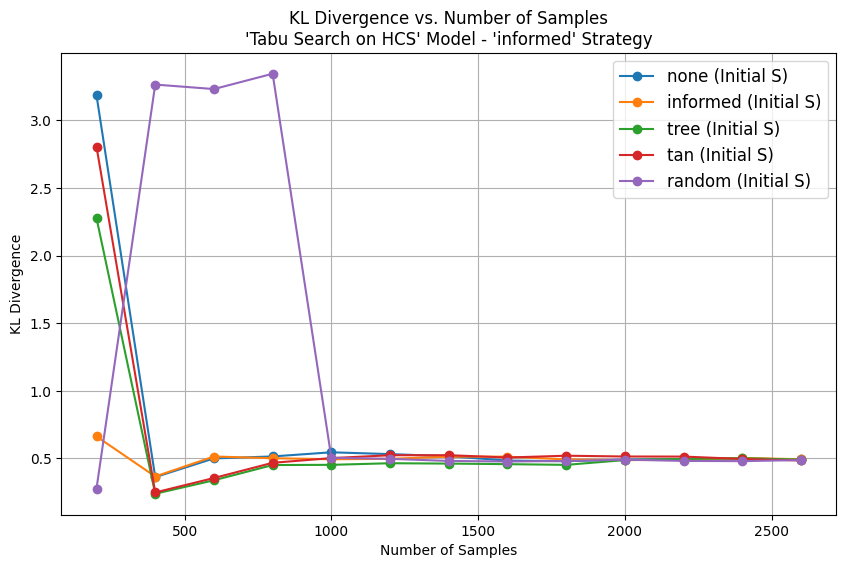

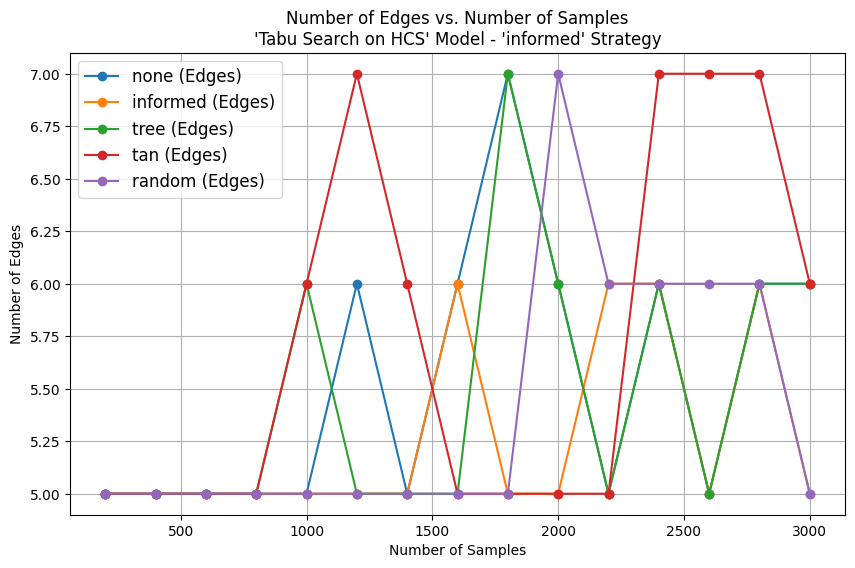

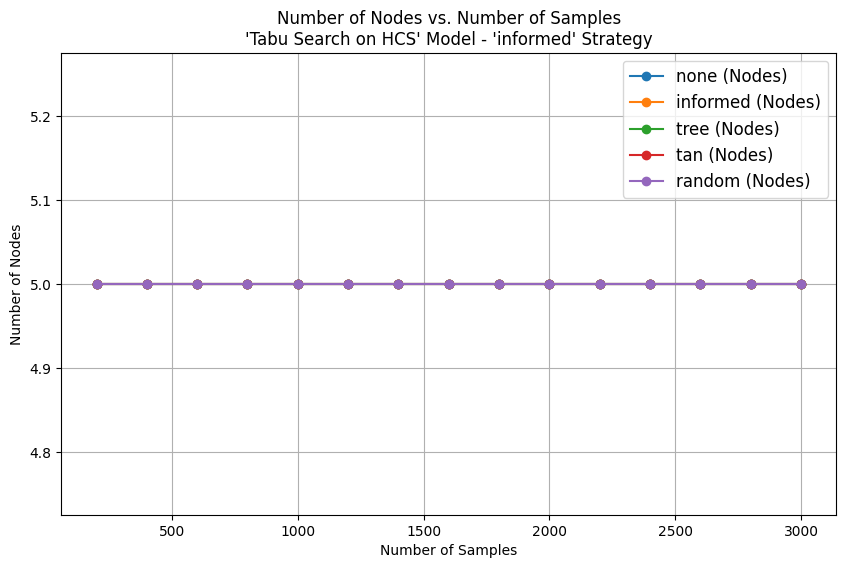

In [66]:
plot_algo_results(results, n_samples_values, 'Tabu Search on HCS', 'informed', max_samples)

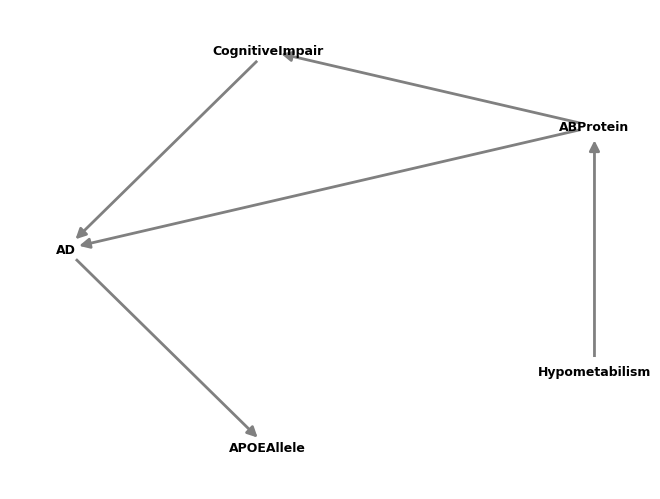

No. of Nodes:  5
No. of Edges:  5


In [67]:
show_network(tabu_model['informed']['model'], "Tabu Search Algorithm BN Model")

# Tabu + Lim

To modify the tabu search such that we limit our search of models only to those that have a maximum of n edges, we can add a conditional check inside the objective_function. If the resultant model has more than n edges, we penalize it heavily

In [68]:
def objective_function_lim(solution, df, state_spaces, max_edges=max_edges):
    edges = decode_structure(solution, df.columns.tolist())
    
    model = BayesianNetwork(edges)
    model_nodes = set(model.nodes())
    
    missing_nodes_penalty = -1e5* (len(df.columns) - len(model_nodes))
    low_edges_penalty = -1e3 if len(edges) < len(df.columns) else 0
    max_edges_penalty = -1e5 if len(edges) > max_edges else 0
    
    if not nx.is_directed_acyclic_graph(model):
        print("Objective Function: Model is not acyclic.")
        return float('inf')

    model = parameter_estimation(model, df, state_spaces)

    if not model.check_model():
        print("Objective Function: Model is not valid.")
        return float('inf')
    
    bic_score = BicScore(df).score(model) + missing_nodes_penalty + low_edges_penalty + max_edges_penalty
    
    return -bic_score


def generate_neighbors(solution, columns, max_parents=5, max_neighbors=150):
    print("Generating neighbors...")
    neighbors = []
    num_nodes = len(columns)

    possible_flips = []
    for i in range(len(solution)):
        row, col = divmod(i, num_nodes)
        if row != col:  
            possible_flips.append(i)

    random.shuffle(possible_flips)

    for i in possible_flips:
        neighbor_solution = solution.copy()
        neighbor_solution[i] = 1 - neighbor_solution[i]  

        edges = decode_structure(neighbor_solution, columns)
        model = nx.DiGraph(edges)

        if not model.nodes():
            continue

        too_many_parents = False
        for node in model.nodes():
            if len(list(model.predecessors(node))) > max_parents:
                too_many_parents = True
                break

        if too_many_parents:
            continue

        if nx.is_directed_acyclic_graph(model) and nx.is_weakly_connected(model):
            neighbors.append(neighbor_solution)
            if len(neighbors) == max_neighbors:
                print(f"Generated {len(neighbors)} neighbors.")
                return neighbors

    print(f"Generated {len(neighbors)} neighbors.")
    return neighbors


def tabu_search_lim(df, state_spaces, initial_solution, max_edges, max_iterations, tabu_list):
    """
    This function performs tabu search on the solution space of DAGs. 
    It uses BIC score as the objective function to optimize.
    """
    best_solution = initial_solution
    best_score = objective_function_lim(initial_solution, df, state_spaces, max_edges)
    
    current_solution = initial_solution
    current_score = best_score
    
    for i in range(max_iterations):
        print(f"Iteration {i + 1} of {max_iterations} in Tabu Search.")
        neighbors = generate_neighbors(current_solution, df.columns.tolist())
        neighbors.sort(key=lambda sol: objective_function_lim(sol, df, state_spaces, max_edges))
        
        found_better_neighbor = False
        
        for neighbor in neighbors:
            if neighbor not in tabu_list:
                neighbor_score = objective_function_lim(neighbor, df, state_spaces, max_edges)
                if neighbor_score < current_score:
                    current_solution = neighbor
                    current_score = neighbor_score
                    if current_score < best_score:
                        best_score = current_score
                        best_solution = current_solution
                    tabu_list.append(neighbor)
                    print(f"Tabu List has {len(tabu_list)} stored solutions.")
                    found_better_neighbor = True
                    break
        
        if not found_better_neighbor:
            print("No better neighbors found. Exiting Tabu search early.")
            break

    edges = decode_structure(best_solution, df.columns.tolist())
    refined_model = BayesianNetwork(edges)
    
    return refined_model, best_score


In [69]:
def structure_learning_tabu_lim(df, S, state_spaces, iterations=iterations, tabu_size=tabu_size, max_edges=max_edges):
    model = structure_learning_with_limit(df, S, state_spaces, max_edges)
    initial_model = nx.DiGraph(model.edges())
    initial_solution = encode_dag(initial_model, df.columns.tolist())
    tabu_list = deque(maxlen=tabu_size)
    best_model, best_score = tabu_search_lim(df, state_spaces, initial_solution, max_edges, iterations, tabu_list)

    print('Tabu Search (Limited Edges)')
    return best_model

In [70]:
tabu_lim_model = run_algorithm(models_to_run['Tabu Search (Limited Edges)'], results['Tabu Search (Limited Edges)'], n_samples_values)
tabu_lim_results = results['Tabu Search (Limited Edges)']

[ 200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.05513477623262996
Successful.
[ 200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.1060228374467945
Successful.
[ 200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.8346988154954863
Successful.
[ 200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.02137599616056482
Successful.
[ 200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.08567591574262184
Successful.
[ 400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  6.619463354869094
Successful.
[ 400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.1224355068565851
Successful.
[ 400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.154361304642293
Successful.
[ 400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 8 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5485432170686466
Successful.
[ 400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.3763849713695223
Successful.
[ 600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.45880051266442307
Successful.
[ 600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5768741693576105
Successful.
[ 600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5201508532924168
Successful.
[ 600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  7.971099668592655
Successful.
[ 600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.15299773032485764
Successful.
[ 800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4415662705275988
Successful.
[ 800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.46800234328932433
Successful.
[ 800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.13455069530596186
Successful.
[ 800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.464006522119957
Successful.
[ 800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4518090900519231
Successful.
[ 1000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5474378398900298
Successful.
[ 1000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4997227218051145
Successful.
[ 1000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.1309649919828136
Successful.
[ 1000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.49294104903385755
Successful.
[ 1000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.45499571520082244
Successful.
[ 1200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5132623358796988
Successful.
[ 1200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4948049163733372
Successful.
[ 1200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5478853827258716
Successful.
[ 1200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4443093442192217
Successful.
[ 1200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 8 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4650570592029979
Successful.
[ 1400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4993900714439167
Successful.
[ 1400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4461971658011228
Successful.
[ 1400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4273037265731115
Successful.
[ 1400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.49005191685536503
Successful.
[ 1400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 8 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.48340015507246514
Successful.
[ 1600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4843787878414199
Successful.
[ 1600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4610564315952874
Successful.
[ 1600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.49510304657947735
Successful.
[ 1600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5165422591935915
Successful.
[ 1600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.49216220041384234
Successful.
[ 1800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4789539206849216
Successful.
[ 1800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4739595701429775
Successful.
[ 1800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.499936405340125
Successful.
[ 1800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5058347508070652
Successful.
[ 1800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.45150613356280545
Successful.
[ 2000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.48002475158199076
Successful.
[ 2000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4515676003324419
Successful.
[ 2000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4810754700103175
Successful.
[ 2000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'ABProtein': Root node: ABProtein and class node: ABProtein are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.48674114518018124
Successful.
[ 2000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 8 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5054867100069963
Successful.
[ 2200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5205433307290646
Successful.
[ 2200, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4593999610031563
Successful.
[ 2200, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5028484568196858
Successful.
[ 2200, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.48910176602582023
Successful.
[ 2200, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4748975552534663
Successful.
[ 2400, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4909355776943297
Successful.
[ 2400, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.49245731960844863
Successful.
[ 2400, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4988117447792595
Successful.
[ 2400, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5171196362280112
Successful.
[ 2400, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4907830984895867
Successful.
[ 2600, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.4932658025931944
Successful.
[ 2600, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.49090426035484297
Successful.
[ 2600, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.48421306568859074
Successful.
[ 2600, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5266862600201231
Successful.
[ 2600, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.46369848519772855
Successful.
[ 2800, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5297031320913969
Successful.
[ 2800, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5862431658528097
Successful.
[ 2800, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5333031768946284
Successful.
[ 2800, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.49926770979413376
Successful.
[ 2800, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.478859158878586
Successful.
[ 3000, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5354105268357768
Successful.
[ 3000, informed, informed ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.5040014479694281
Successful.
[ 3000, informed, tree ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Tabu Search (Limited Edges)
KL Divergence Value:  0.49552647336731404
Successful.
[ 3000, informed, tan ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.522659212663481
Successful.
[ 3000, informed, random ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Tabu Search (Limited Edges)
KL Divergence Value:  0.48489835689054145
Successful.


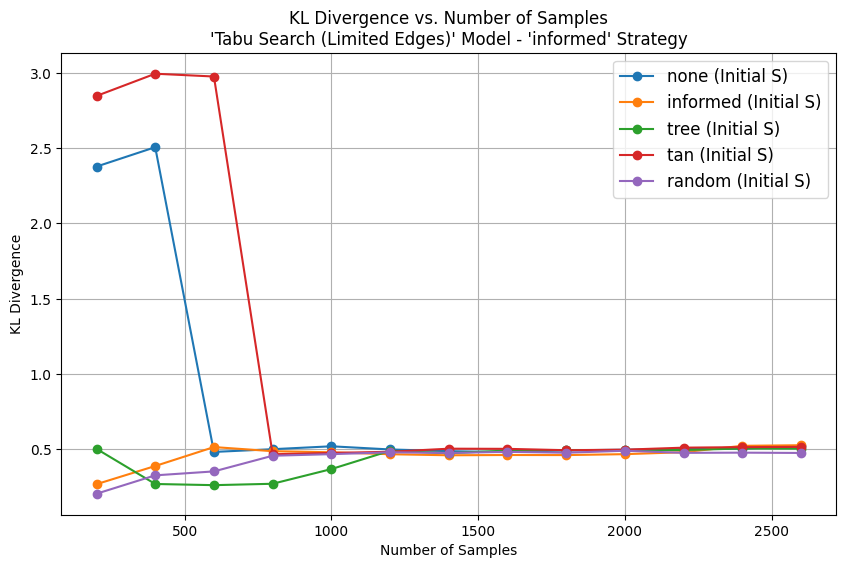

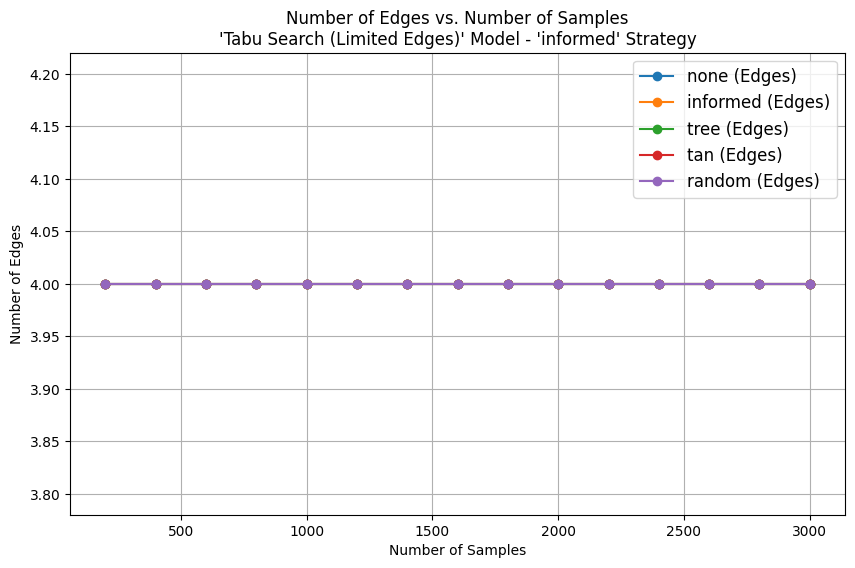

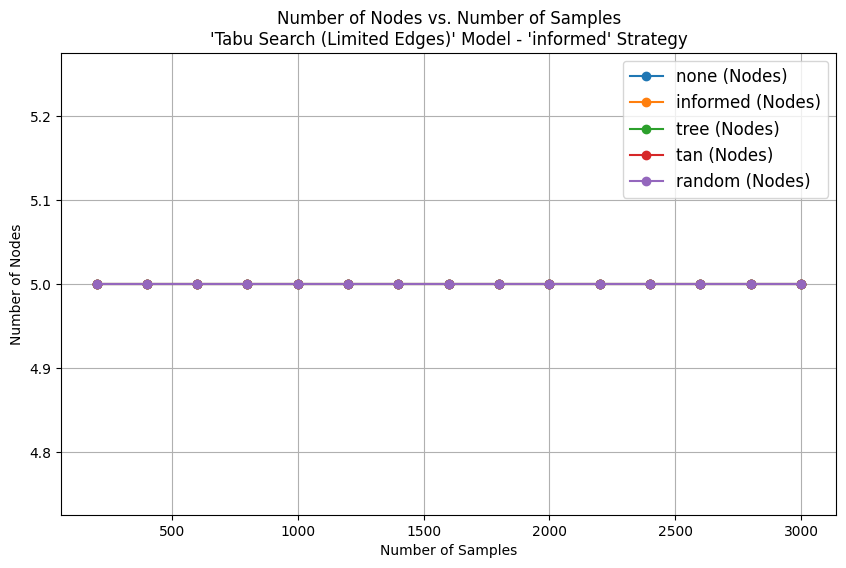

In [71]:
plot_algo_results(results, n_samples_values, 'Tabu Search (Limited Edges)', 'informed', max_samples)

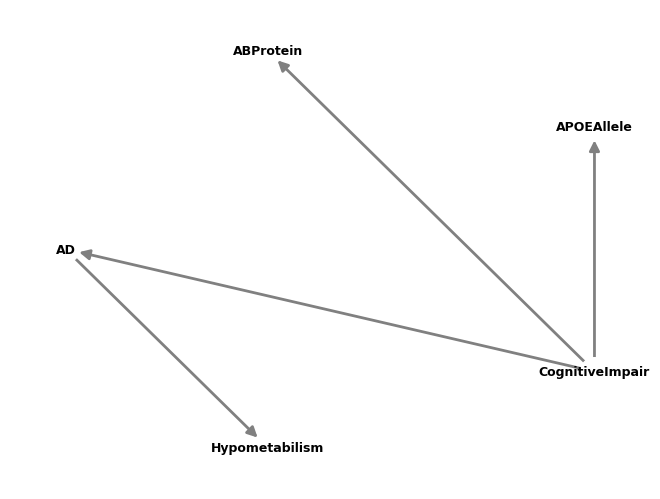

No. of Nodes:  5
No. of Edges:  4


In [72]:
show_network(tabu_lim_model['informed']['model'], "Tabu Search (Limited Edges) Algorithm BN Model")

# BMA + Lim + Tabu

**Model Robustness:** By using multiple bands (or subsets) of the data for initial structure learning, we're essentially obtaining multiple "views" or "perspectives" on the potential relationships in the data. This can make the resultant structure more robust to potential overfitting to any particular subset of the data.

**Traversing Search Space:** The Bayesian Network structure learning problem is NP-hard, which means there's a combinatorially large number of potential structures. By using multiple subsets of the data, we might land on different starting structures, allowing us to explore diverse parts of the search space.

**Averaging & Escaping Local Minima:** The idea is somewhat akin to "ensemble methods" in machine learning. By learning multiple structures, we get a sense of the "average" or "consensus" structure. The tabu search phase then refines this structure using the entire dataset.

In [73]:
def structure_learning_ensemble(df, S, state_space, num_candidate_structures=num_candidate_structures, iterations=iterations, tabu_size=tabu_size, num_edges_limit=max_edges):
    min_edges = num_edges_limit
    
    num_bands = 3
    
    band_size = len(df) // num_bands
    bands = [df.iloc[i*band_size:(i+1)*band_size] for i in range(num_bands)]
    candidate_models = hcs_rr_bands(df, S, state_spaces, num_candidate_structures, num_bands)
    
    for data_band in bands:
        model = structure_learning_with_limit(data_band, S, state_spaces)
    final_models = []

    print(f"Generated {len(candidate_models)} candidate structures.")

    tabu_list = deque(maxlen=tabu_size)
    edge_counts = defaultdict(int)

    print(f"Starting Tabu Search (Size: {tabu_size}) for refinement...")
    for candidate in candidate_models:
        # print("Refining a candidate structure...")
        
        initial_solution = encode_dag(candidate, df.columns.tolist())
        refined_model, refined_score = tabu_search_lim(df, state_space, initial_solution, num_edges_limit, iterations, tabu_list)
        
        # print(f"Candidate Structure: BIC Score = {refined_score}")
        
        final_models.append(refined_model)

        
    print(f"Generated {len(final_models)} final candidate structures.")

    averaged_structure = perform_structure_averaging_models(final_models, df, state_space, max_edges=len(df.columns)*3)


    final_network = BayesianNetwork(averaged_structure.edges())
    
    print('Final Model Assembled')
    print('Max Edges: ', max_edges)
    
    return final_network


In [74]:
bma_lim_tabu_models = run_algorithm(models_to_run['Ensemble III (+ Tabu Search + Limited Edges)'], results['Ensemble III (+ Tabu Search + Limited Edges)'], n_samples_values)
bma_lim_tabu_results = results['Ensemble III (+ Tabu Search + Limited Edges)']

[ 200, informed, none ] : Try 1 out of 20 with 0 Successful_trials.


  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbor

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'APOEAllele': Root node: APOEAllele and class node: APOEAllele are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 4 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
G

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbor

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 8 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Ge

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
G

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 8 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'APOEAllele': Root node: APOEAllele and class node: APOEAllele are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbor

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbor

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 14 neighbor

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbor

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 8 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 10 neighbors.
Tabu List has 3 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 4 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Ge

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
G

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbor

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbor

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 8 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'Hypometabilism': Root node: Hypometabilism and class node: Hypometabilism are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 8 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 4 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 5 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 6 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 11 neighbors.
No better neighbors found. Exiting Tabu search early.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 9 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Ge

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'AD': Root node: AD and class node: AD are identical


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 13 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

Skipping TAN structure learning for class node 'CognitiveImpair': Root node: CognitiveImpair and class node: CognitiveImpair are identical
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 8 s

  0%|          | 0/15 [00:00<?, ?it/s]

Chosen model has 2 components with tied covariance type.
Chosen model has 3 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Chosen model has 2 components with tied covariance type.
Generating 4 candidate structures for 3 bands...


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
Generated 12 candidate structures.


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO


  0%|          | 0/1000000 [00:00<?, ?it/s]

ALGO
LIMIT
Generated 12 candidate structures.
Starting Tabu Search (Size: 200) for refinement...
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 1 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 2 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 3 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 15 neighbors.
Tabu List has 4 stored solutions.
Iteration 1 of 4 in Tabu Search.
Generating neighbors...
Generated 20 neighbors.
Tabu List has 5 stored solutions.
Iteration 2 of 4 in Tabu Search.
Generating neighbors...
Generated 12 neighbors.
Tabu List has 6 stored solutions.
Iteration 3 of 4 in Tabu Search.
Generating neighbors...
Generated 16 neighbors.
Tabu List has 7 stored solutions.
Iteration 4 of 4 in Tabu Search.
Generating neighbors...
Generated 17 neighbors.
Tabu List has 8 s

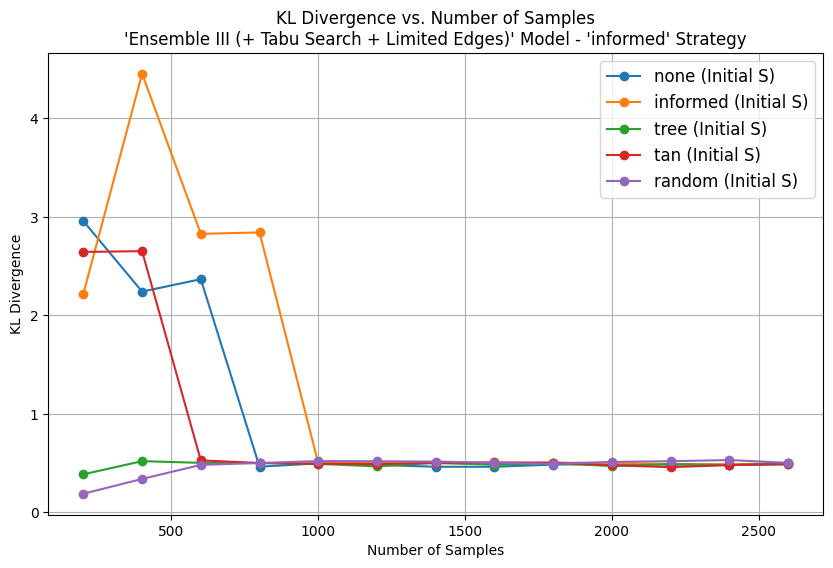

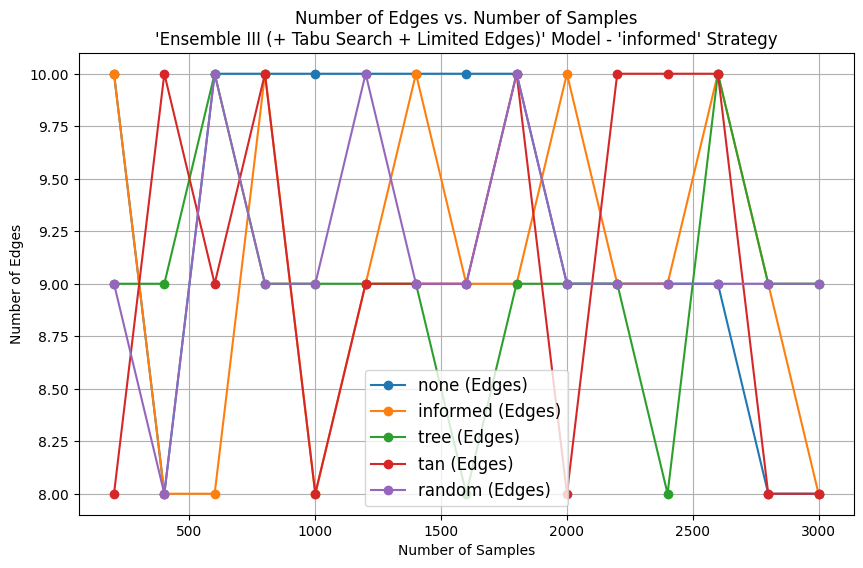

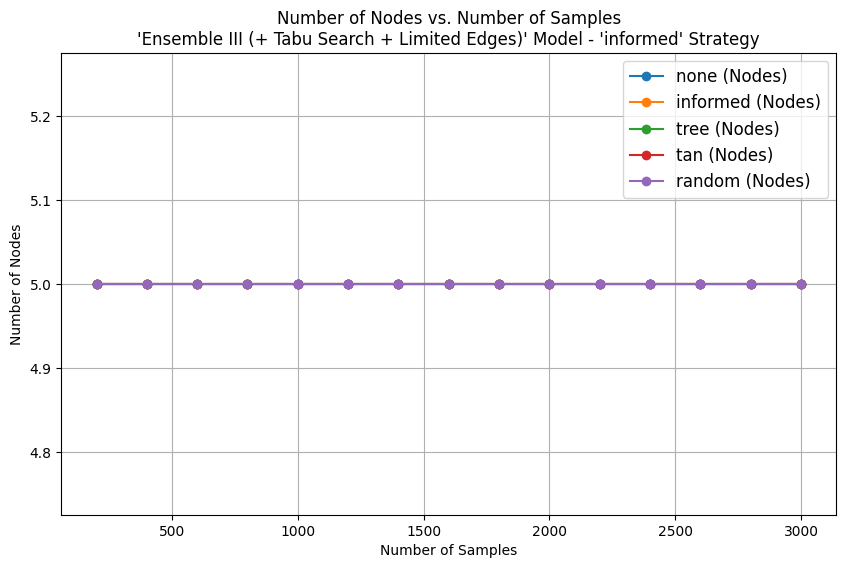

In [75]:
plot_algo_results(results, n_samples_values, 'Ensemble III (+ Tabu Search + Limited Edges)', 'informed', max_samples)

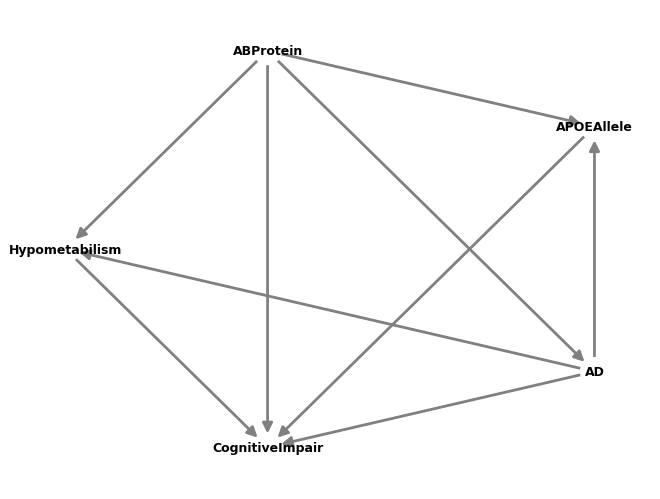

No. of Nodes:  5
No. of Edges:  9


In [76]:
show_network(bma_lim_tabu_models['informed']['model'], "Ensemble III (+ Tabu Search + Limited Edges) Algorithm BN Model")

# Data Collection

In [77]:
def results_to_dataframe(results, n_samples_values):
    data = []

    for algo, latent_infos in results.items():
        for latent_info, structures in latent_infos.items():
            for initial_S_key, metrics in structures.items():
                if len(metrics['kl_divergence']) != len(n_samples_values):
                    # print("The number of samples does not match the number of metric entries.")
                    for n_samples, kl_divergence, num_edges, num_nodes, edges in zip(metrics['kl_divergence'], metrics['num_edges'], metrics['num_nodes'], metrics['edges']):
                        data.append({
                            'algorithm': algo,
                            'latent_info': latent_info,
                            'initial_S_key': initial_S_key,
                            'kl_divergence': kl_divergence,
                            'num_edges': num_edges,
                            'num_nodes': num_nodes,
                            'edges': edges
                        })
                else:
                    for n_samples, kl_divergence, num_edges, num_nodes, edges in zip(n_samples_values, metrics['kl_divergence'], metrics['num_edges'], metrics['num_nodes'], metrics['edges']):
                        data.append({
                            'algorithm': algo,
                            'latent_info': latent_info,
                            'initial_S_key': initial_S_key,
                            'n_samples': n_samples,
                            'kl_divergence': kl_divergence,
                            'num_edges': num_edges,
                            'num_nodes': num_nodes,
                            'edges': edges
                        })

    results_df = pd.DataFrame(data)
    return results_df

In [78]:
results_df = results_to_dataframe(results, n_samples_values)
results_df.to_csv(f'full_results_samples={max_samples}.csv')
results_df.tail(20)

algorithm latent_info initial_S_key  \
430  Ensemble III (+ Tabu Search + Limited Edges)    informed           tan   
431  Ensemble III (+ Tabu Search + Limited Edges)    informed           tan   
432  Ensemble III (+ Tabu Search + Limited Edges)    informed           tan   
433  Ensemble III (+ Tabu Search + Limited Edges)    informed           tan   
434  Ensemble III (+ Tabu Search + Limited Edges)    informed           tan   
435  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
436  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
437  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
438  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
439  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
440  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
441  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
442  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
443  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
444  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
445  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
446  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
447  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
448  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   
449  Ensemble III (+ Tabu Search + Limited Edges)    informed        random   

     n_samples  kl_divergence  num_edges  num_nodes  \
430       2200       0.464725         10          5   
431       2400       0.440019         10          5   
432       2600       0.466147         10          5   
433       2800       0.525972          8          5   
434       3000       0.475029          8          5   
435        200       0.020125          9          5   
436        400       0.082312          8          5   
437        600       0.458194         10          5   
438        800       0.470948          9          5   
439       1000       0.511106          9          5   
440       1200       0.514676         10          5   
441       1400       0.529516          9          5   
442       1600       0.505308          9          5   
443       1800       0.505984         10          5   
444       2000       0.493610          9          5   
445       2200       0.471094          9          5   
446       2400       0.566182          9          5   
447       2600       0.513419          9          5   
448       2800       0.508313          9          5   
449       3000       0.480011          9          5   

                                                 edges  
430  [(AD, ABProtein), (AD, APOEAllele), (AD, Cogni...  
431  [(ABProtein, AD), (ABProtein, APOEAllele), (AB...  
432  [(Hypometabilism, APOEAllele), (CognitiveImpai...  
433  [(CognitiveImpair, ABProtein), (AD, ABProtein)...  
434  [(APOEAllele, Hypometabilism), (APOEAllele, Co...  
435  [(Hypometabilism, CognitiveImpair), (AD, APOEA...  
436  [(Hypometabilism, AD), (Hypometabilism, Cognit...  
437  [(AD, CognitiveImpair), (AD, Hypometabilism), ...  
438  [(Hypometabilism, AD), (Hypometabilism, ABProt...  
439  [(CognitiveImpair, AD), (CognitiveImpair, Hypo...  
440  [(AD, CognitiveImpair), (AD, ABProtein), (Cogn...  
441  [(ABProtein, APOEAllele), (ABProtein, AD), (AB...  
442  [(AD, Hypometabilism), (AD, APOEAllele), (APOE...  
443  [(CognitiveImpair, Hypometabilism), (Cognitive...  
444  [(AD, CognitiveImpair), (AD, ABProtein), (AD, ...  
445  [(CognitiveImpair, AD), (Hypometabilism, Cogni...  
446  [(AD, Hypometabilism), (AD, APOEAllele), (APOE...  
447  [(Hypometabilism, AD), (Hypometabilism, ABProt...  
448  [(APOEAllele, CognitiveImpair), (APOEAllele, H...  
449  [(APOEAllele, ABProtein), (APOEAllele, Hypomet...

In [79]:
results_df.to_csv(f'full_results_samples={max_samples}.csv')

In [80]:
file_path = 'full_results_samples=6000.csv'
results_df = pd.read_csv(file_path)

In [81]:
res_df = results_df.copy()
# res_df.drop('Unnamed: 0', axis=1, inplace=True)

# Grouping the data by 'algorithm' and 'initial_S_key' and calculating the average KL divergence
average_kl_df = res_df.groupby(['algorithm', 'initial_S_key']).agg({'kl_divergence': 'mean'}).reset_index()
average_kl_df_sorted = average_kl_df.sort_values('kl_divergence')
average_kl_df_sorted.to_csv(f'top_5_results_samples={max_samples}.csv')


In [82]:
average_kl_df_sorted.head()

algorithm initial_S_key  kl_divergence
2                                       Basic HCS        random       0.449429
8                           Ensemble (MI Ranking)           tan       0.459013
11  Ensemble II (+ Random Restarts + BIC Ranking)          none       0.459729
17   Ensemble III (+ Tabu Search + Limited Edges)        random       0.461575
3                                       Basic HCS           tan       0.466579

In [83]:
"""Summarizing the performance of the algorithms by calculating the lowest KL, average KL, highest KL,
average number of edges, and average number of nodes for each algorithm."""

res_df = results_df.copy()
grouped_by_algo = res_df.groupby('algorithm')

summary_by_algo = grouped_by_algo.agg({
    'kl_divergence': ['min', 'mean', 'max'],
    'num_edges': 'mean',
    'num_nodes': 'mean'
}).reset_index()

summary_by_algo.columns = [
    'Algorithm', 
    'Lowest KL', 
    'Average KL', 
    'Highest KL', 
    'Average Num of Edges', 
    'Average Num of Nodes'
]



In [84]:
summary_by_algo.to_csv(f'Algo_Summary_Samples={max_samples}.csv')
summary_by_algo

Algorithm  Lowest KL  Average KL  \
0                                      Basic HCS   0.012432    0.551772   
1                          Ensemble (MI Ranking)   0.040437    0.640009   
2  Ensemble II (+ Random Restarts + BIC Ranking)   0.102337    0.567458   
3   Ensemble III (+ Tabu Search + Limited Edges)   0.014722    0.568886   
4                    Tabu Search (Limited Edges)   0.031418    0.741198   
5                             Tabu Search on HCS   0.026756    0.761299   

   Highest KL  Average Num of Edges  Average Num of Nodes  
0    7.872333              5.760000              5.000000  
1   10.989432              6.426667              4.986667  
2    7.510448              9.006667              5.000000  
3    8.672385              9.033333              5.000000  
4    8.522172              4.000000              5.000000  
5    8.139213              5.866667              5.000000